In [1]:
import drawing
import numpy as np

import os

import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

n_mixtures = 40
hidden_size = 200
input_size = 3
batch_size = 128
n_epochs = 500
max_length = 1200
lr = 1e-3
n_lstm_layers = 5
eps = 1e-6
model_name = "20210811_Prediction-5LSTM-40Mixtures-200Hidden-128Batch-Mask"


cuda:1


In [2]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes_og = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]

In [3]:
# plt.plot(sorted(stroke_lens))
# plt.show()
# x = strokes_og[:,:,0].flatten()
# x = x[x!=0]
# x = x[x<5]
# x = x[x>-5]
# x = np.array(sorted(x))
# x.shape
# plt.plot(x)
# plt.show()
# plt.plot(np.log(x))
# plt.show()
# _=plt.hist(x, bins=100)
# plt.show()
# y = strokes_og[:,:,1].flatten()
# y = y[y!=0]
# y = y[y<5]
# y = y[y>-5]
# y = np.array(sorted(y))
# y.shape
# plt.plot(y)
# plt.show()
# plt.plot(np.log(y))
# plt.show()
# _=plt.hist(y, bins=100)

In [4]:
def standarize(strokes, lengths):
    points_to_consider = np.zeros((lengths.sum() - 2*len(lengths), 2))
    idx = 0
    for i in range(0, len(lengths)):
        #print(strokes[i][1:lengths[i], 0:2].shape)
        points_to_consider[idx:idx+lengths[i]-2] = strokes[i][1:lengths[i]-1, 0:2]
        idx += lengths[i] - 2
    means = points_to_consider.mean(axis=0)
    std = points_to_consider.std(axis=0)
    
    result = strokes.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] -= means
        result[i, 1:lengths[i]-1, 0:2] /= std
    return result, means, std

def destandarize(strokes_standarized, lengths, means, std):
    result = strokes_standarized.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] *= std
        result[i, 1:lengths[i]-1, 0:2] += means
    return result

def preprocess(strokes_og, stroke_lens, strings, string_lengths):
    # My preprocesisng is simple - all strokes start with (0, 0, 0) nd end with (0, 0, 1)

    # to this end we remove all full length strokes to make space for the end 
    # (0, 0, 1) as the end point

    indices = stroke_lens != 1200
    strokes_og = strokes_og[indices]
    stroke_lens = stroke_lens[indices]
    strings = strings[indices]
    string_lengths = string_lengths[indices]

    # Now we make sure that every stroke has the correct 
    # start point of (0, 0, 0) and end point of (0, 0, 1)
    strokes_og[:,0,2] = 0
    for i in range(strokes_og.shape[0]):
        strokes_og[i, stroke_lens[i], 2] = 1
    stroke_lens += 1
    
    # Standarize the coordinates separaetly to have zero mean and std dev 1
    standarized_strokes, means, std = standarize(strokes_og, stroke_lens)
    
    return standarized_strokes, means, std, stroke_lens, strings, string_lengths



In [5]:
strokes, means, std, stroke_lengths, strings, string_lengths  = preprocess(
    strokes_og, stroke_lens, strings, string_lens)
print(strokes.shape, stroke_lengths.shape, means.shape, std.shape, strings.shape, string_lengths.shape)


(11846, 1200, 3) (11846,) (2,) (2,) (11846, 75) (11846,)


In [6]:
strokes[2][stroke_lengths[2]-2:stroke_lengths[2]+2]

array([[-0.61420643, -0.1501907 ,  1.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32)

In [7]:
import matplotlib.pyplot as plt

def offsets_to_coords(offsets):
    """
    convert from offsets to coordinates
    """
    return np.concatenate([np.cumsum(offsets[:, :2], axis=0), offsets[:, 2:3]], axis=1)


def draw(offsets, plot_end_points=True):
    strokes = offsets_to_coords(offsets)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k')
            if plot_end_points:
                ax.plot(x, y, 'ro')
            stroke = []
    if stroke:
        coords = list(zip(*stroke))
        ax.plot(coords[0], coords[1], 'k')
        stroke = []

    padding = 10
    
    ax.set_xlim(strokes[:,0].min() - padding, strokes[:,0].max() + padding)
    ax.set_ylim(strokes[:,1].min() - padding, strokes[:,1].max() + padding)

    ax.set_aspect('equal')
    plt.tick_params(
        axis='both',
        left='off',
        top='off',
        right='off',
        bottom='off',
        labelleft='off',
        labeltop='off',
        labelright='off',
        labelbottom='off'
    )
    plt.show()
    plt.close('all')

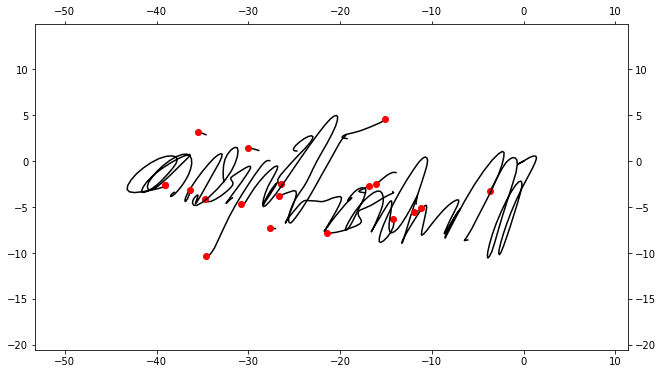

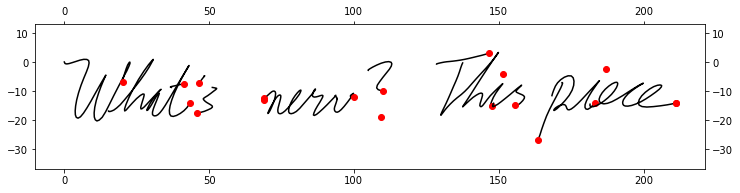

What 's new? This piece


In [8]:
draw(strokes[0])
res2 = destandarize(strokes, stroke_lengths, means, std) # for checking
draw(res2[0])
print(drawing.decode_ascii(strings[0]))

In [9]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes, stroke_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        self.mask = self.getMask()
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx], self.mask[idx]
    
    def getMask(self):
        mask = np.ones((self.strokes.shape[0], self.strokes.shape[1]-1))
        for i in range(self.strokes.shape[0]):
            # The mask needs to be 1 not till the last index or the index corresponding 
            # to the last character of stroke, but instead one before as the last char is 
            # always a special character (0, 0, 1) denoting the end of the stroke and 
            # we do not want to include loss computation on this as there is no point 
            # in teh stroke after this.
            mask[i][self.stroke_lengths[i]-1:] = 0
        return mask
    
train_dataset = HandwritingDataset(strokes[:10000], stroke_lengths[:10000])
test_dataset = HandwritingDataset(strokes[10000:], stroke_lengths[10000:])


In [10]:
dl = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=2,
    drop_last=True)

k = iter(dl)
for j in range(4):
    print("JJJJJJJJJJJJJJJJJ:", j)
    s, l, m = next(k)
    l0 = l[0]
    l1 = l[1]
    l
    s.shape
    m.shape

    print("Testing the 0th position of every stroke")
    s[:,0,:]

    print("testing the length location of stroke")
    s[0,l0-2:l0+2, :]
    s[1,l1-2:l1+2, :]

    print("testing the length location of mask")
    m[0,l0-2:l0+2]
    m[1,l1-2:l1+2]

JJJJJJJJJJJJJJJJJ: 0


tensor([785, 555], dtype=torch.int16)

torch.Size([2, 1200, 3])

torch.Size([2, 1199])

Testing the 0th position of every stroke


tensor([[0., 0., 0.],
        [0., 0., 0.]])

testing the length location of stroke


tensor([[-0.7685,  0.1935,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

tensor([[0.2580, 0.0266, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])

testing the length location of mask


tensor([1., 0., 0., 0.], dtype=torch.float64)

tensor([1., 0., 0., 0.], dtype=torch.float64)

JJJJJJJJJJJJJJJJJ: 1


tensor([666, 818], dtype=torch.int16)

torch.Size([2, 1200, 3])

torch.Size([2, 1199])

Testing the 0th position of every stroke


tensor([[0., 0., 0.],
        [0., 0., 0.]])

testing the length location of stroke


tensor([[-0.6467,  0.1203,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

tensor([[-0.2114,  0.1716,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

testing the length location of mask


tensor([1., 0., 0., 0.], dtype=torch.float64)

tensor([1., 0., 0., 0.], dtype=torch.float64)

JJJJJJJJJJJJJJJJJ: 2


tensor([1028,  509], dtype=torch.int16)

torch.Size([2, 1200, 3])

torch.Size([2, 1199])

Testing the 0th position of every stroke


tensor([[0., 0., 0.],
        [0., 0., 0.]])

testing the length location of stroke


tensor([[-0.3979, -0.4252,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

tensor([[0.3861, 0.2240, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])

testing the length location of mask


tensor([1., 0., 0., 0.], dtype=torch.float64)

tensor([1., 0., 0., 0.], dtype=torch.float64)

JJJJJJJJJJJJJJJJJ: 3


tensor([596, 562], dtype=torch.int16)

torch.Size([2, 1200, 3])

torch.Size([2, 1199])

Testing the 0th position of every stroke


tensor([[0., 0., 0.],
        [0., 0., 0.]])

testing the length location of stroke


tensor([[-0.5876, -0.7694,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

tensor([[-0.0602, -0.5483,  1.0000],
        [ 0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

testing the length location of mask


tensor([1., 0., 0., 0.], dtype=torch.float64)

tensor([1., 0., 0., 0.], dtype=torch.float64)

In [11]:
from einops import rearrange 

class Prediction(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Prediction, self).__init__()
        self.input_size = input_size # 3
        self.hidden_size = hidden_size # 900
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(input_size+hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(input_size+hidden_size, hidden_size, batch_first=True)
        self.lstm4 = nn.LSTM(input_size+hidden_size, hidden_size, batch_first=True)
        self.lstm5 = nn.LSTM(input_size+hidden_size, hidden_size, batch_first=True)
        self.linearLayer = nn.Linear(5*hidden_size, output_size)
        
    def forward(self, x, prev_state):
        bs = x.shape[0]
        out_1, hid_1 = self.lstm1(x, prev_state[0])
        out_2, hid_2 = self.lstm2(torch.cat([x, out_1], dim=-1), prev_state[1])
        out_3, hid_3 = self.lstm3(torch.cat([x, out_2], dim=-1), prev_state[2])
        out_4, hid_4 = self.lstm3(torch.cat([x, out_3], dim=-1), prev_state[3])
        out_5, hid_5 = self.lstm3(torch.cat([x, out_4], dim=-1), prev_state[4])
        out_6 = rearrange(torch.cat([out_1, out_2, out_3, out_4, out_5], dim=-1), 'b l h -> (b l) h')
        out_7 = self.linearLayer(out_6)
        out_7 = rearrange(out_7, '(b l) o -> b l o', b = bs)
        return out_7, [hid_1, hid_2, hid_3, hid_4, hid_5]

In [12]:
inputs = torch.randn(2, 10, 3)
lengths = torch.tensor([5, 3])
inputs[0, 5:, :] = 0
inputs[1, 3:, :] = 0
inputs
lengths
p = Prediction(3, 4, 7)
h = torch.zeros(1, 2, 4)
prev_state = ((h, h), (h, h), (h, h), (h,h), (h,h))
p(inputs, prev_state)[0].shape

tensor([[[-0.1550, -0.6728, -0.1661],
         [ 0.3359, -0.5965, -0.1839],
         [-0.2843, -1.0316, -0.3143],
         [-0.8762,  1.5478,  1.2012],
         [-0.3904,  1.7365,  0.6884],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.3685, -0.6105, -1.7546],
         [ 1.7214,  1.3937, -1.0409],
         [-1.4405,  0.6566, -0.9029],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]]])

tensor([5, 3])

torch.Size([2, 10, 7])

In [13]:
def get_mixture_params_from_output(outputs, bias=0):
    # outputs:  b, max_len-1, 6*n_mixtures+1
    pis = nn.Softmax(2)(outputs[:,:,:n_mixtures]*(1+bias))
    mus = rearrange(outputs[:,:,n_mixtures:3*n_mixtures], 'b l (n d) -> b l n d', d=2)
    
    sigmas = rearrange(torch.exp(outputs[:,:,3*n_mixtures:5*n_mixtures] - bias), 'b l (n d) -> b l n d', d=2) + eps
    phos = rearrange((1-eps)*torch.tanh(outputs[:,:,5*n_mixtures:6*n_mixtures]), 'b l (n d) -> b l n d', d=1)
    
    covs = torch.zeros(outputs.shape[0], outputs.shape[1], n_mixtures, 2, 2, device=device)
    covs[:,:,:,0,0] = sigmas[:,:,:,0]**2
    covs[:,:,:,1,1] = sigmas[:,:,:,1]**2
    covs[:,:,:,0,1] = phos[:,:,:,0] * sigmas[:,:,:,0] * sigmas[:,:,:,1]
    covs[:,:,:,1,0] = covs[:,:,:,0,1]
    
    return pis, mus, covs

def get_mixture_distributions_from_output(outputs):
    pis, mus, covs = get_mixture_params_from_output(outputs)
    
    distributions = torch.distributions.MultivariateNormal(mus, covs)
    return pis, distributions

def get_pen_lift_probs_from_output(outputs):
    return 1/(1 + torch.exp(outputs[:,:,-1]))

def nll(outputs, targets, mask_batch):
    # outputs:  b, max_len-1, 6*n_mixtures+1
    # targets: b, max_len-1, 3
    outputs = outputs.to(device)
    targets = targets.to(device)
    
    target_coords = targets[:,:,0:2].unsqueeze(2).repeat_interleave(
            torch.tensor([n_mixtures], device=device), dim=2)
    # target_coords: b, max_len-1, n_mixtures, 3
    stroke_lift = targets[:,:,-1] # b, max_len-1, 1
    
    pis, distributions = get_mixture_distributions_from_output(outputs)
    es = get_pen_lift_probs_from_output(outputs)

    probs = distributions.log_prob(target_coords) + eps
    loss1 = - torch.logsumexp(torch.log(pis) + probs, dim=2)
    loss2 = - torch.log(es)*stroke_lift
    loss3 = - torch.log(1 - es)*(1-stroke_lift)
    loss_per_point = loss1 + loss2 + loss3
    loss_per_point *= mask_batch
    
    return loss_per_point.sum()/outputs.shape[0]

In [14]:
def get_initial_prev_states(mode='train'):
    dim = batch_size if mode == 'train' else 1
    h01 = torch.zeros(1, dim, hidden_size, device=device)
    c01 = torch.zeros(1, dim, hidden_size, device=device)
    h02 = torch.zeros(1, dim, hidden_size, device=device)
    c02 = torch.zeros(1, dim, hidden_size, device=device)
    h03 = torch.zeros(1, dim, hidden_size, device=device)
    c03 = torch.zeros(1, dim, hidden_size, device=device)
    h04 = torch.zeros(1, dim, hidden_size, device=device)
    c04 = torch.zeros(1, dim, hidden_size, device=device)
    h05 = torch.zeros(1, dim, hidden_size, device=device)
    c05 = torch.zeros(1, dim, hidden_size, device=device)
    
    prev_states = [(h01, c01), (h02, c02), (h03, c03), (h04, c04), (h05, c05)]
    return prev_states

def get_next_point(model, point_prev, prev_states, bias=0):
    with torch.no_grad():
        outputs, prev_states = model(point_prev.unsqueeze(0).unsqueeze(0), prev_states)
        
        es = get_pen_lift_probs_from_output(outputs)
        pis, mus, covs = get_mixture_params_from_output(outputs, bias)
        
        sample_index = 0
        if n_mixtures > 1:
            sample_index = np.random.choice(
                range(n_mixtures),
                p = pis.squeeze().cpu().numpy())

        pen_off = torch.tensor(
            [np.random.binomial(1,es.item())],
            device=device)

        sample_point = torch.tensor(
            np.random.multivariate_normal(
                mus.squeeze(0).squeeze(0)[sample_index].cpu().numpy(),
                covs.squeeze(0).squeeze(0)[sample_index].cpu().numpy()),
            device=device)
        
        return torch.cat((sample_point, pen_off), dim=0), prev_states
        
def sample(model, bias=0):
    timestamps = max_length
    sample_stroke = torch.zeros(timestamps, 3, device=device)
    prev_states = get_initial_prev_states("sample")
    stroke_end = False
    for i in range(timestamps-2):
        prev_point = sample_stroke[i]
        new_point, prev_states = get_next_point(model, prev_point, prev_states, bias)
        sample_stroke[i+1] = new_point
        if(new_point[0] == 0 and new_point[1] == 0 and new_point[2] == 1):
            print("Model decided to end the stroke")
            stroke_end = True
            break
    if (not stroke_end):
        sample_stroke[timestamps-1][2] = 1
    return sample_stroke

In [15]:
from einops import rearrange

def get_inputs_targets_from_batch(strokes_batch, lengths_batch):
    inputs = strokes_batch[:, :-1, :]
    targets = strokes_batch[:, 1:, :]
    return inputs, targets

def train_batch(model, optimizer, strokes_batch, lengths_batch, mask_batch, prev_states):
    optimizer.zero_grad()
    inputs, targets = get_inputs_targets_from_batch(strokes_batch, lengths_batch)
    outputs, _ = model(inputs, prev_states)
    loss = nll(outputs, targets, mask_batch)
    loss.backward()
    #### Do Gradient clipping here if need be
    torch.nn.utils.clip_grad_value_(model.parameters(), 10)
    torch.nn.utils.clip_grad_value_(loss, 100)
    optimizer.step()
    return loss.item()

def save_model(model, model_name):
    base_dir = "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/"
    torch.save({
        'model_state_dict': model.state_dict(),
    }, base_dir + model_name)
    
def train(model, optimizer, train_dataloader, num_epochs):
    losses = []
    n_iter = 0
    total_loss = 0
    start = time.time()
    
    print_every = 50
    sample_every = print_every * 5
    
    prev_states = get_initial_prev_states("train")
    for epoch in range(num_epochs):
        
        for strokes_batch, lengths_batch, mask_batch in train_dataloader:
            strokes_batch = strokes_batch.to(device)
            lengths_batch = lengths_batch.to(device)
            mask_batch = mask_batch.to(device)
            
            batch_loss = train_batch(
                model,
                optimizer,
                strokes_batch,
                lengths_batch,
                mask_batch,
                prev_states)
            prev_states = [(x[0].detach(), x[1].detach()) for x in prev_states]
            total_loss += batch_loss
            
            if n_iter % print_every == 0:
                avg_loss = total_loss/print_every
                losses.append(avg_loss)
                print(f"iteration: {n_iter} "\
                      f"of {len(train_dataloader) * num_epochs}, " \
                      f"avg_loss: {avg_loss:.2f}, "\
                      f"timeSinceStart: {time.time() - start :.2f}, "\
                      f"Epoch: {epoch}")
                total_loss = 0
                save_model(model, model_name)
                
            if n_iter % sample_every == 0:
                for bias in [0, 0.5, 1, 5]:
                    sample_stroke = sample(model, bias)
                    sample_stroke[1:, 0:2] *= torch.tensor(std, device=device)
                    sample_stroke[1:, 0:2] += torch.tensor(means, device=device)
                    draw(sample_stroke.cpu(), plot_end_points=False)
                
            n_iter += 1
    return losses

In [16]:

model = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)
optim = torch.optim.Adam(model.parameters(), lr = lr)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    drop_last=True)


/home/miniconda3/lib/python3.8/site-packages/torch/_tensor.py:992: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /opt/conda/conda-bld/pytorch_1627542741873/work/build/aten/src/ATen/core/TensorBody.h:802.)
  return self._grad


iteration: 0 of 39000, avg_loss: 45.25, timeSinceStart: 4.29, Epoch: 0


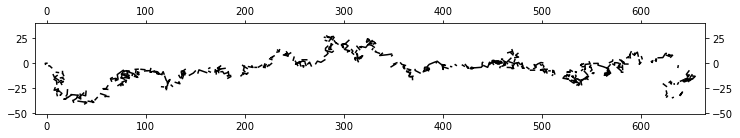

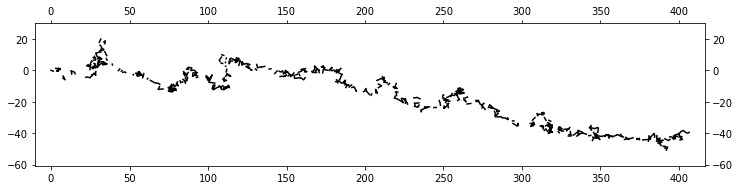

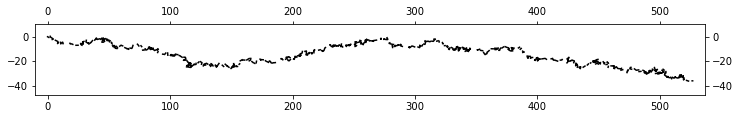

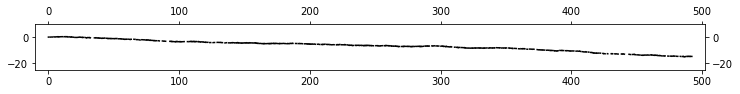

iteration: 50 of 39000, avg_loss: 781.82, timeSinceStart: 60.27, Epoch: 0
iteration: 100 of 39000, avg_loss: -447.78, timeSinceStart: 106.62, Epoch: 1
iteration: 150 of 39000, avg_loss: -1058.51, timeSinceStart: 153.08, Epoch: 1
iteration: 200 of 39000, avg_loss: -1315.03, timeSinceStart: 199.60, Epoch: 2
iteration: 250 of 39000, avg_loss: -1407.39, timeSinceStart: 246.26, Epoch: 3


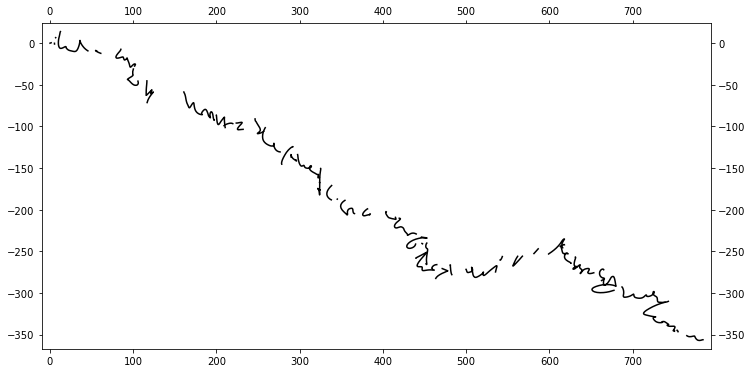

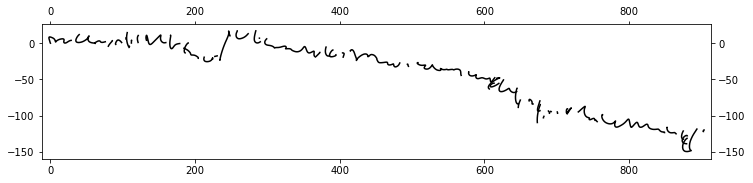

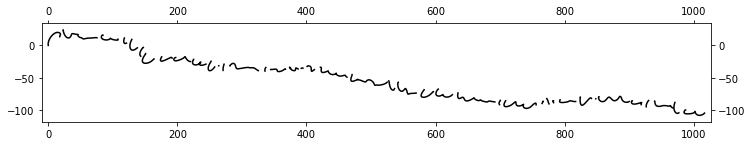

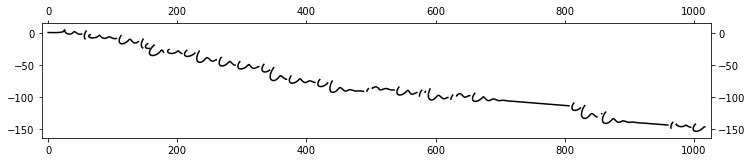

iteration: 300 of 39000, avg_loss: -1464.85, timeSinceStart: 300.48, Epoch: 3
iteration: 350 of 39000, avg_loss: -1507.62, timeSinceStart: 347.16, Epoch: 4
iteration: 400 of 39000, avg_loss: -1563.78, timeSinceStart: 393.79, Epoch: 5
iteration: 450 of 39000, avg_loss: -1612.50, timeSinceStart: 440.43, Epoch: 5
iteration: 500 of 39000, avg_loss: -1607.03, timeSinceStart: 487.23, Epoch: 6


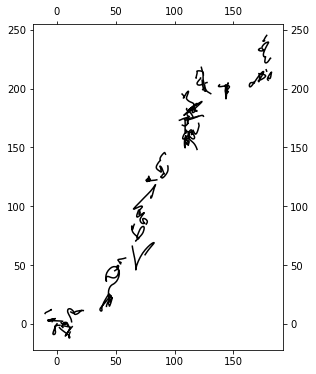

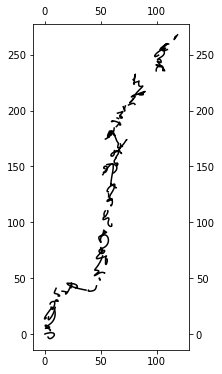

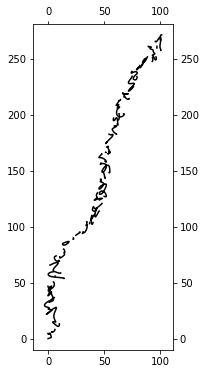

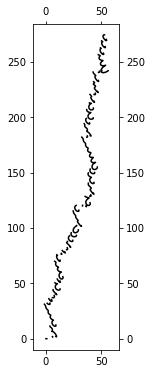

iteration: 550 of 39000, avg_loss: -1609.20, timeSinceStart: 541.61, Epoch: 7
iteration: 600 of 39000, avg_loss: -1664.13, timeSinceStart: 588.30, Epoch: 7
iteration: 650 of 39000, avg_loss: -1671.69, timeSinceStart: 634.90, Epoch: 8
iteration: 700 of 39000, avg_loss: -1700.47, timeSinceStart: 681.80, Epoch: 8
iteration: 750 of 39000, avg_loss: -1717.19, timeSinceStart: 728.68, Epoch: 9


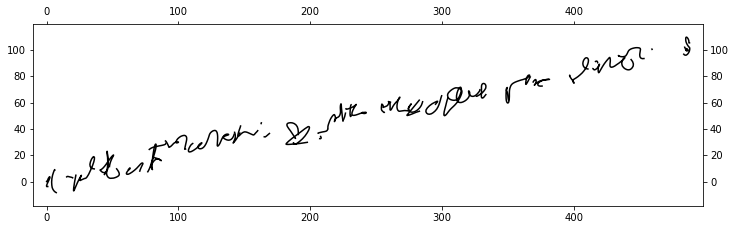

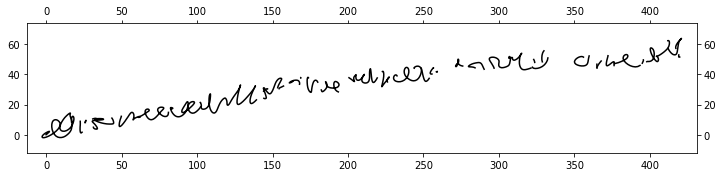

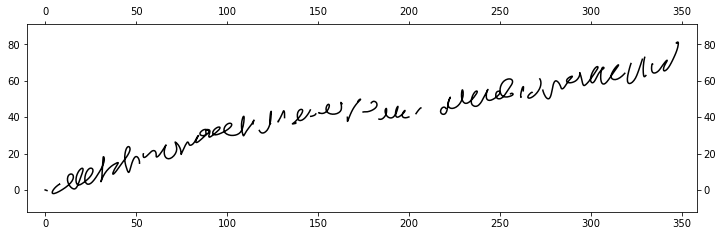

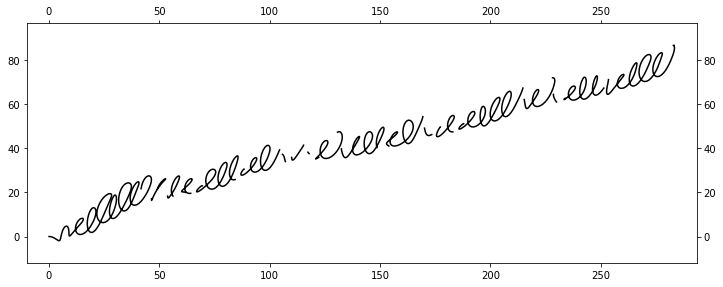

iteration: 800 of 39000, avg_loss: -1713.02, timeSinceStart: 783.32, Epoch: 10
iteration: 850 of 39000, avg_loss: -1716.12, timeSinceStart: 829.90, Epoch: 10
iteration: 900 of 39000, avg_loss: -1733.33, timeSinceStart: 876.66, Epoch: 11
iteration: 950 of 39000, avg_loss: -1747.69, timeSinceStart: 923.52, Epoch: 12
iteration: 1000 of 39000, avg_loss: -1769.60, timeSinceStart: 970.31, Epoch: 12


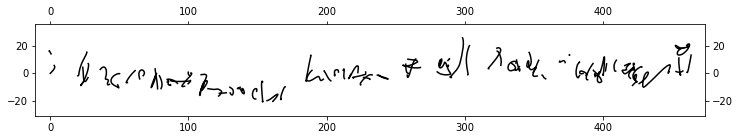

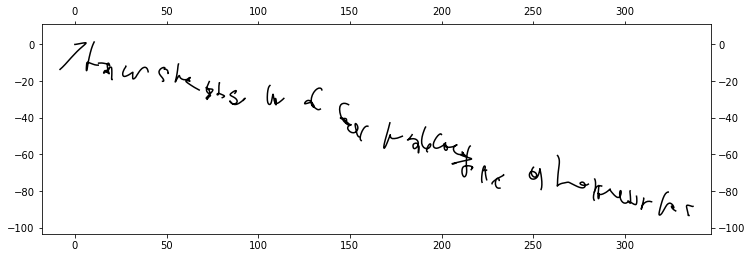

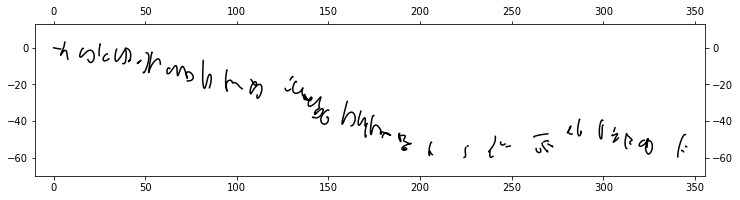

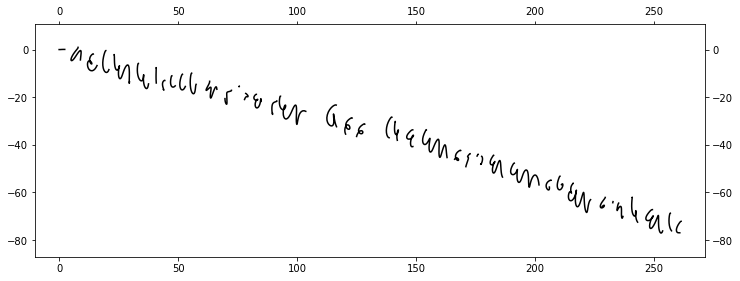

iteration: 1050 of 39000, avg_loss: -1771.99, timeSinceStart: 1025.01, Epoch: 13
iteration: 1100 of 39000, avg_loss: -1774.19, timeSinceStart: 1071.85, Epoch: 14
iteration: 1150 of 39000, avg_loss: -1783.60, timeSinceStart: 1118.64, Epoch: 14
iteration: 1200 of 39000, avg_loss: -1803.24, timeSinceStart: 1165.45, Epoch: 15
iteration: 1250 of 39000, avg_loss: -1821.63, timeSinceStart: 1212.22, Epoch: 16


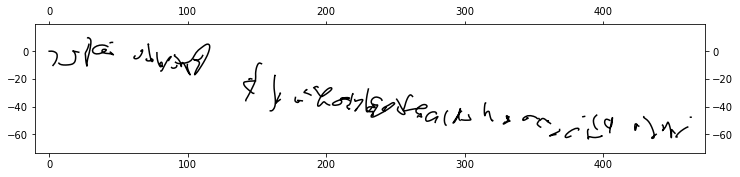

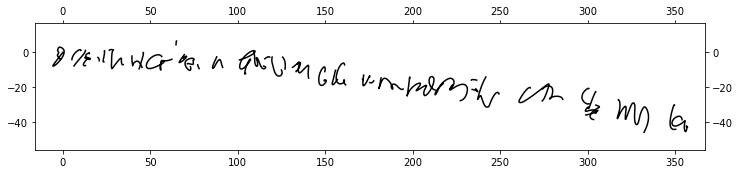

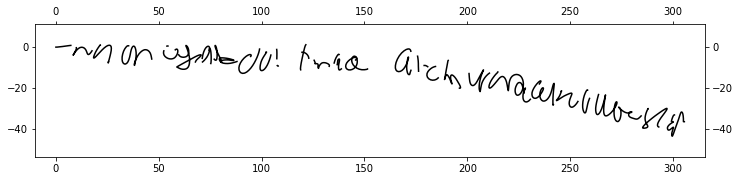

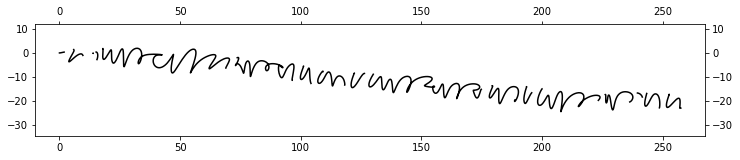

iteration: 1300 of 39000, avg_loss: -1825.66, timeSinceStart: 1266.93, Epoch: 16
iteration: 1350 of 39000, avg_loss: -1829.40, timeSinceStart: 1313.52, Epoch: 17
iteration: 1400 of 39000, avg_loss: -1825.43, timeSinceStart: 1360.33, Epoch: 17
iteration: 1450 of 39000, avg_loss: -1848.43, timeSinceStart: 1407.30, Epoch: 18
iteration: 1500 of 39000, avg_loss: -1845.87, timeSinceStart: 1454.13, Epoch: 19


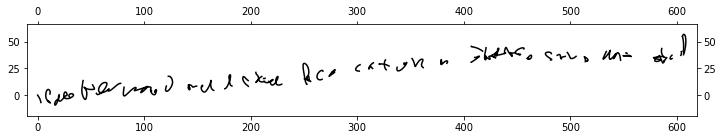

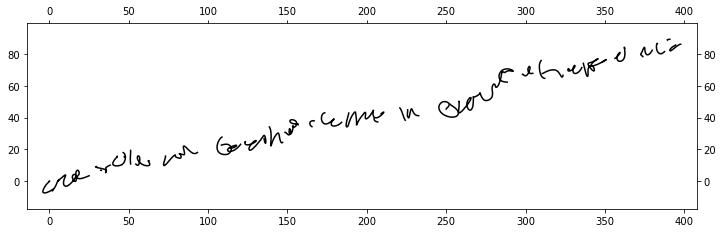

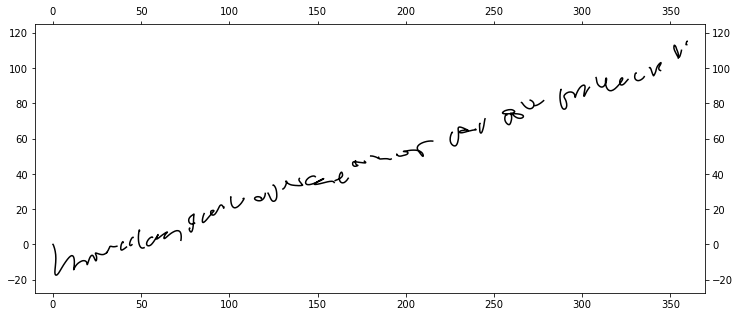

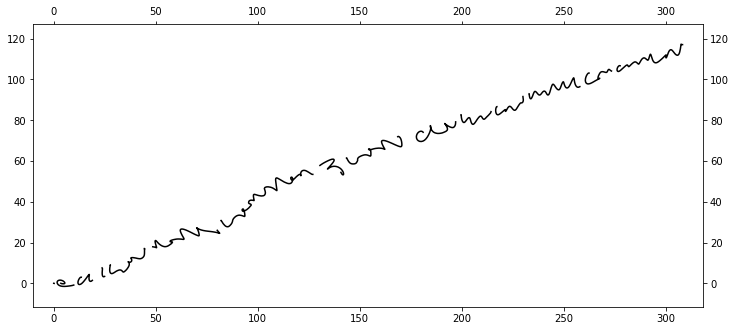

iteration: 1550 of 39000, avg_loss: -1862.66, timeSinceStart: 1508.63, Epoch: 19
iteration: 1600 of 39000, avg_loss: -1876.44, timeSinceStart: 1555.47, Epoch: 20
iteration: 1650 of 39000, avg_loss: -1870.13, timeSinceStart: 1602.42, Epoch: 21
iteration: 1700 of 39000, avg_loss: -1898.78, timeSinceStart: 1649.24, Epoch: 21
iteration: 1750 of 39000, avg_loss: -1914.54, timeSinceStart: 1695.98, Epoch: 22


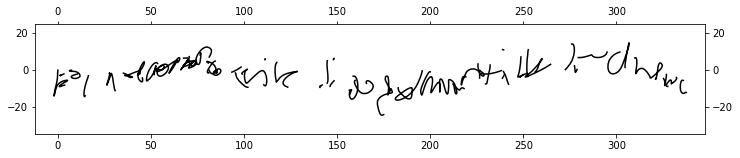

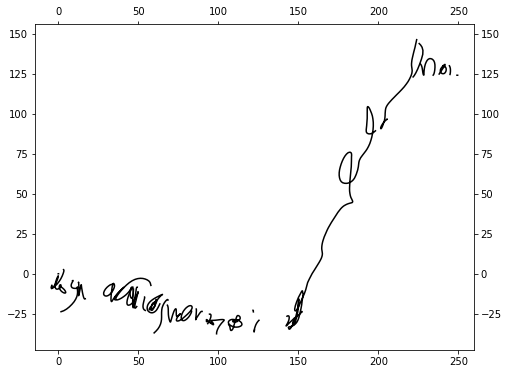

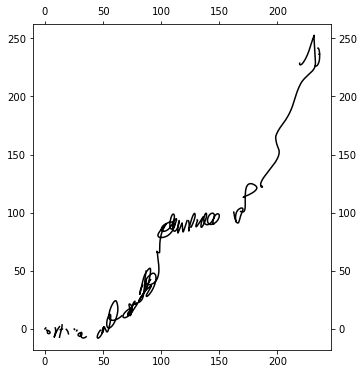

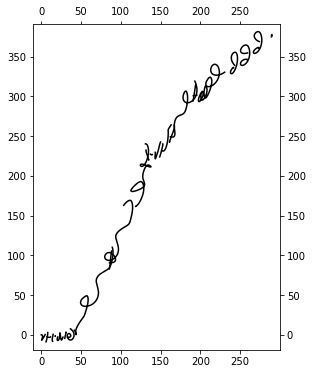

iteration: 1800 of 39000, avg_loss: -1915.55, timeSinceStart: 1750.56, Epoch: 23
iteration: 1850 of 39000, avg_loss: -1921.37, timeSinceStart: 1797.35, Epoch: 23
iteration: 1900 of 39000, avg_loss: -1926.04, timeSinceStart: 1844.28, Epoch: 24
iteration: 1950 of 39000, avg_loss: -1945.61, timeSinceStart: 1891.07, Epoch: 25
iteration: 2000 of 39000, avg_loss: -1941.37, timeSinceStart: 1937.77, Epoch: 25


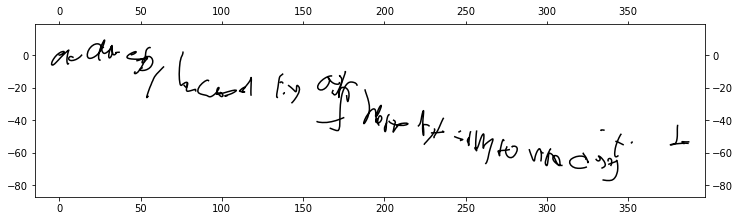

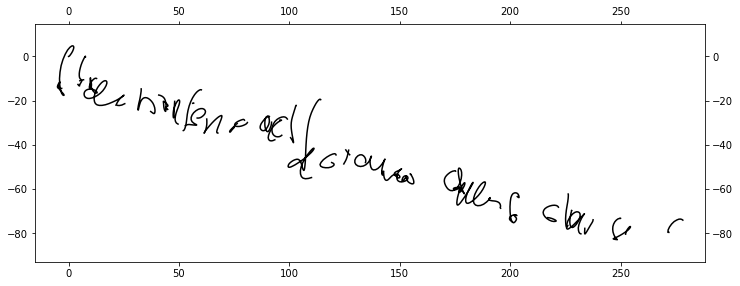

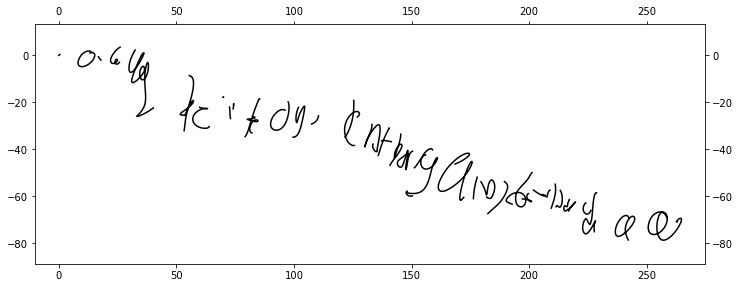

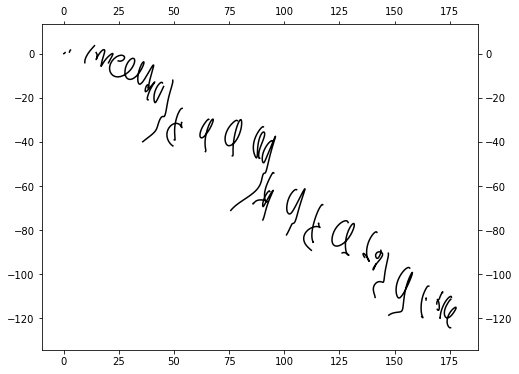

iteration: 2050 of 39000, avg_loss: -1950.09, timeSinceStart: 1992.44, Epoch: 26
iteration: 2100 of 39000, avg_loss: -1960.55, timeSinceStart: 2039.06, Epoch: 26
iteration: 2150 of 39000, avg_loss: -1961.58, timeSinceStart: 2085.88, Epoch: 27
iteration: 2200 of 39000, avg_loss: -1975.83, timeSinceStart: 2132.73, Epoch: 28
iteration: 2250 of 39000, avg_loss: -1977.43, timeSinceStart: 2179.53, Epoch: 28


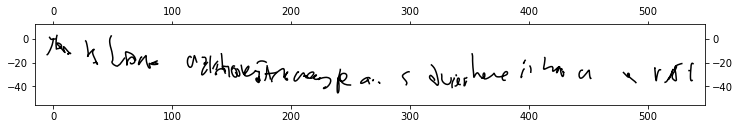

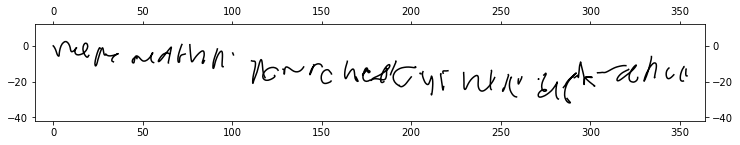

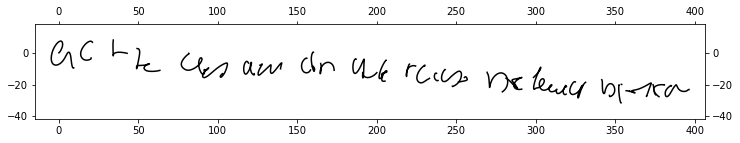

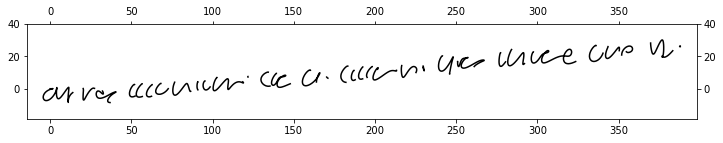

iteration: 2300 of 39000, avg_loss: -1968.88, timeSinceStart: 2233.89, Epoch: 29
iteration: 2350 of 39000, avg_loss: -1985.71, timeSinceStart: 2280.82, Epoch: 30
iteration: 2400 of 39000, avg_loss: -1974.48, timeSinceStart: 2327.70, Epoch: 30
iteration: 2450 of 39000, avg_loss: -2014.21, timeSinceStart: 2373.81, Epoch: 31
iteration: 2500 of 39000, avg_loss: -1990.38, timeSinceStart: 2418.75, Epoch: 32


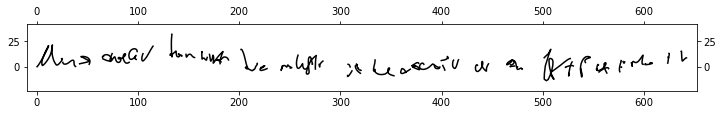

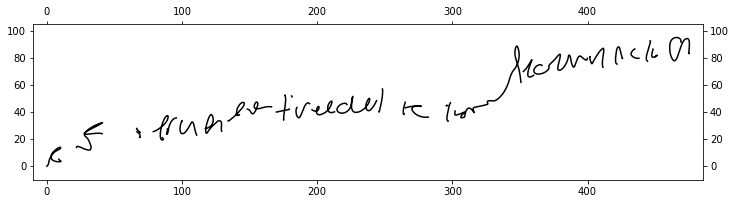

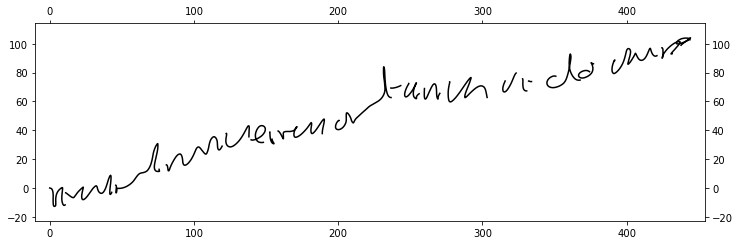

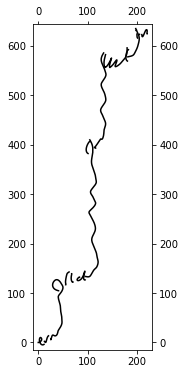

iteration: 2550 of 39000, avg_loss: -2002.21, timeSinceStart: 2471.00, Epoch: 32
iteration: 2600 of 39000, avg_loss: -1997.87, timeSinceStart: 2515.90, Epoch: 33
iteration: 2650 of 39000, avg_loss: -2007.02, timeSinceStart: 2560.73, Epoch: 33
iteration: 2700 of 39000, avg_loss: -2003.09, timeSinceStart: 2605.60, Epoch: 34
iteration: 2750 of 39000, avg_loss: -1998.92, timeSinceStart: 2650.43, Epoch: 35


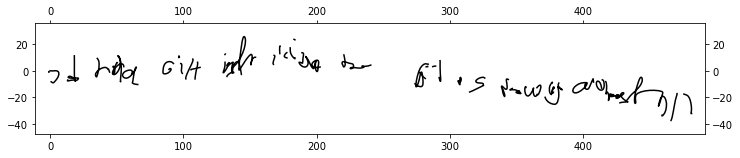

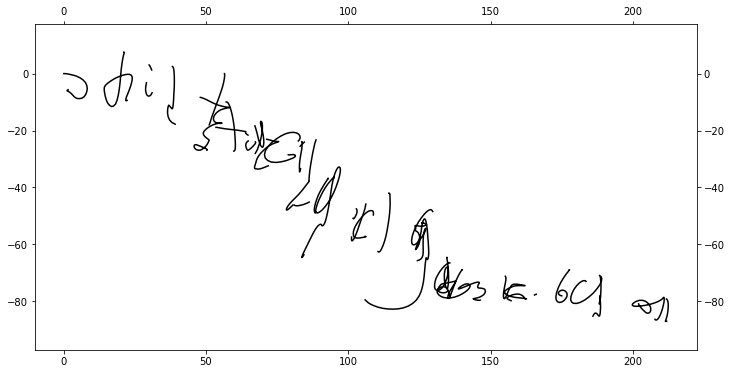

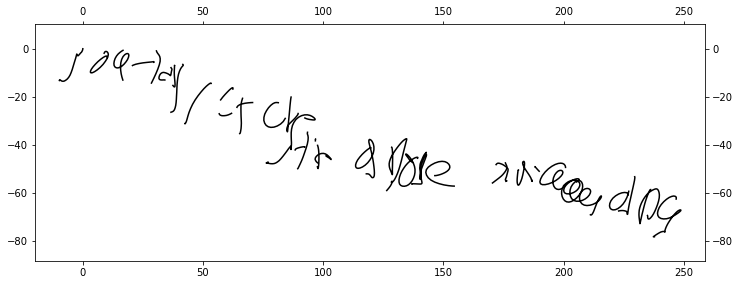

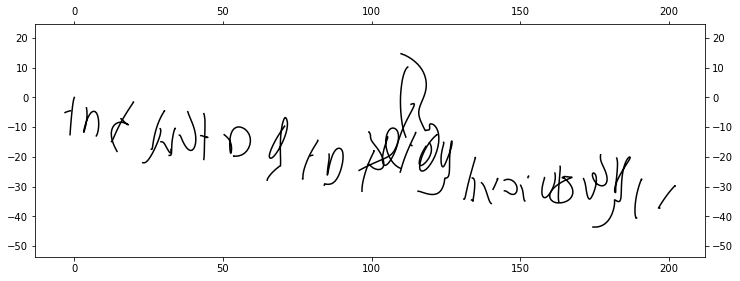

iteration: 2800 of 39000, avg_loss: -2028.04, timeSinceStart: 2702.46, Epoch: 35
iteration: 2850 of 39000, avg_loss: -2035.66, timeSinceStart: 2747.23, Epoch: 36
iteration: 2900 of 39000, avg_loss: -2019.94, timeSinceStart: 2791.94, Epoch: 37
iteration: 2950 of 39000, avg_loss: -2030.31, timeSinceStart: 2836.63, Epoch: 37
iteration: 3000 of 39000, avg_loss: -2041.46, timeSinceStart: 2881.27, Epoch: 38


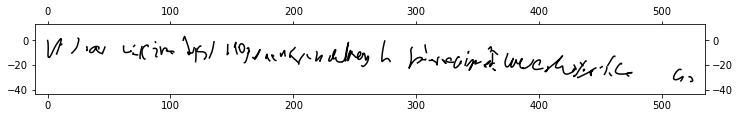

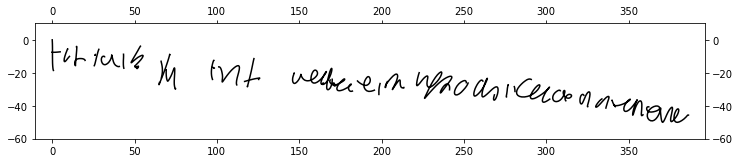

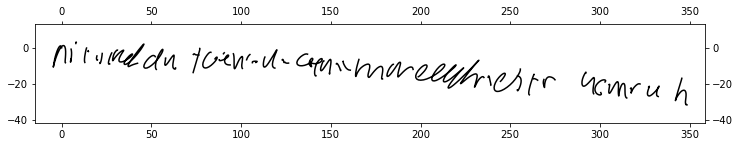

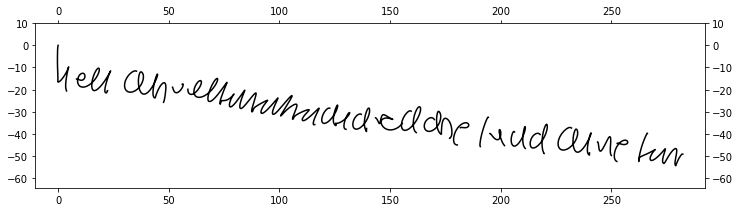

iteration: 3050 of 39000, avg_loss: -2034.34, timeSinceStart: 2933.19, Epoch: 39
iteration: 3100 of 39000, avg_loss: -2029.30, timeSinceStart: 2977.69, Epoch: 39
iteration: 3150 of 39000, avg_loss: -2032.30, timeSinceStart: 3022.38, Epoch: 40
iteration: 3200 of 39000, avg_loss: -2042.36, timeSinceStart: 3067.14, Epoch: 41
iteration: 3250 of 39000, avg_loss: -2043.02, timeSinceStart: 3112.10, Epoch: 41


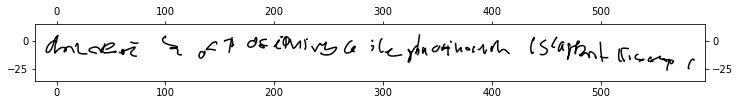

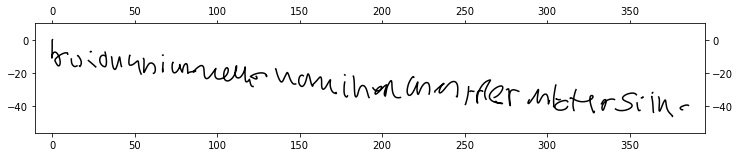

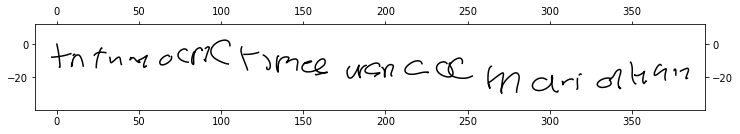

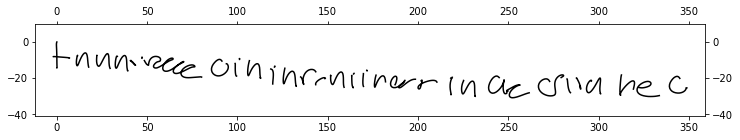

iteration: 3300 of 39000, avg_loss: -2058.74, timeSinceStart: 3164.25, Epoch: 42
iteration: 3350 of 39000, avg_loss: -2066.61, timeSinceStart: 3208.93, Epoch: 42
iteration: 3400 of 39000, avg_loss: -2057.07, timeSinceStart: 3253.71, Epoch: 43
iteration: 3450 of 39000, avg_loss: -2075.44, timeSinceStart: 3298.60, Epoch: 44
iteration: 3500 of 39000, avg_loss: -2065.02, timeSinceStart: 3343.46, Epoch: 44


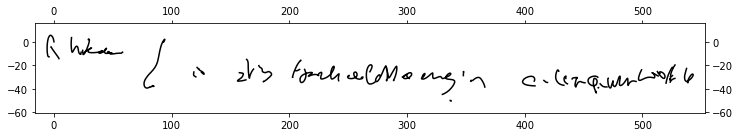

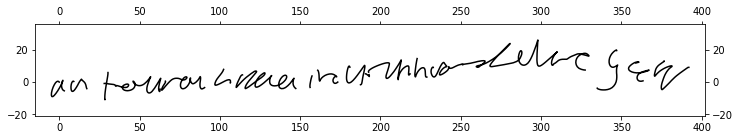

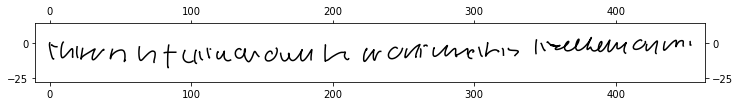

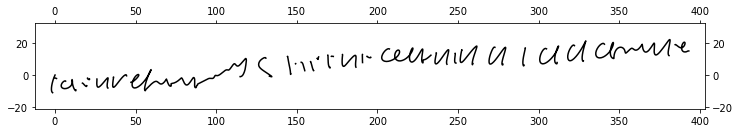

iteration: 3550 of 39000, avg_loss: -2062.28, timeSinceStart: 3395.67, Epoch: 45
iteration: 3600 of 39000, avg_loss: -2065.54, timeSinceStart: 3440.36, Epoch: 46
iteration: 3650 of 39000, avg_loss: -2083.87, timeSinceStart: 3485.22, Epoch: 46
iteration: 3700 of 39000, avg_loss: -2081.60, timeSinceStart: 3529.93, Epoch: 47
iteration: 3750 of 39000, avg_loss: -2089.71, timeSinceStart: 3574.56, Epoch: 48


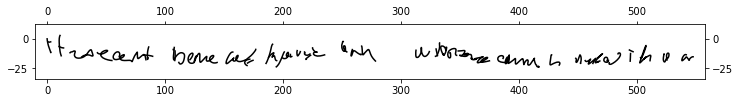

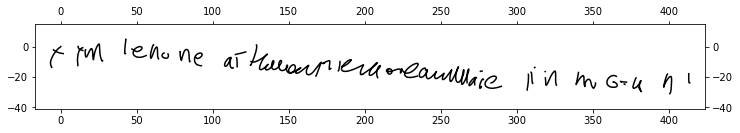

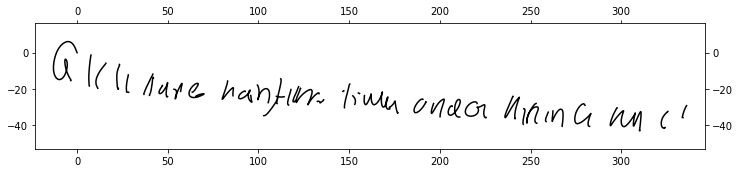

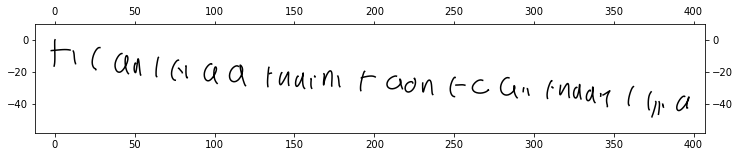

iteration: 3800 of 39000, avg_loss: -2104.07, timeSinceStart: 3626.41, Epoch: 48
iteration: 3850 of 39000, avg_loss: -2086.83, timeSinceStart: 3670.98, Epoch: 49
iteration: 3900 of 39000, avg_loss: -2099.95, timeSinceStart: 3715.60, Epoch: 50
iteration: 3950 of 39000, avg_loss: -2096.04, timeSinceStart: 3760.31, Epoch: 50
iteration: 4000 of 39000, avg_loss: -2108.65, timeSinceStart: 3804.98, Epoch: 51


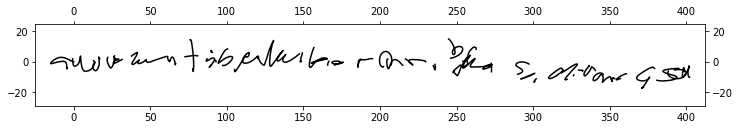

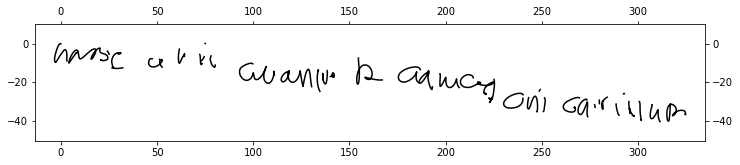

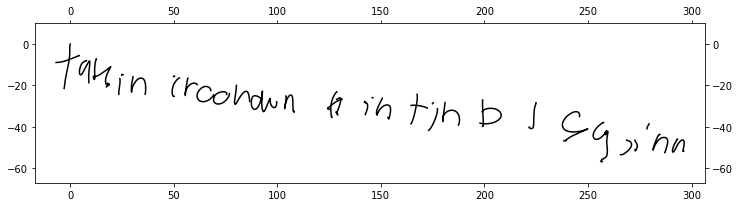

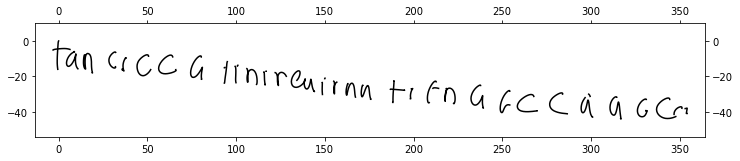

iteration: 4050 of 39000, avg_loss: -2110.51, timeSinceStart: 3857.04, Epoch: 51
iteration: 4100 of 39000, avg_loss: -2110.68, timeSinceStart: 3901.85, Epoch: 52
iteration: 4150 of 39000, avg_loss: -2108.39, timeSinceStart: 3946.73, Epoch: 53
iteration: 4200 of 39000, avg_loss: -2120.24, timeSinceStart: 3991.62, Epoch: 53
iteration: 4250 of 39000, avg_loss: -2119.39, timeSinceStart: 4036.53, Epoch: 54


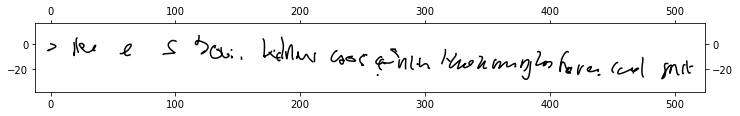

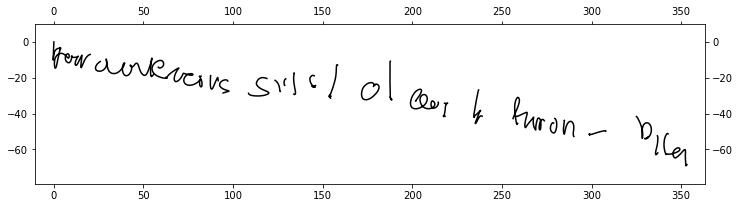

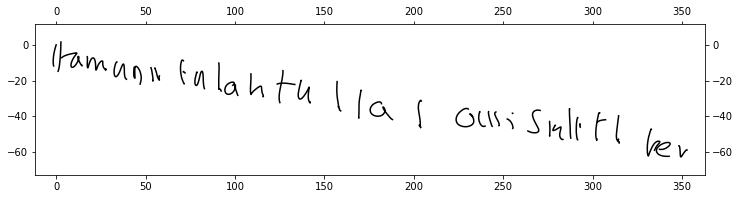

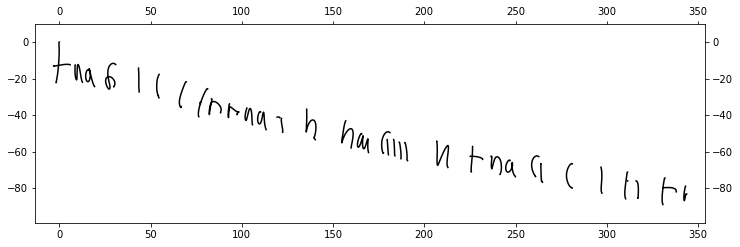

iteration: 4300 of 39000, avg_loss: -2116.40, timeSinceStart: 4088.66, Epoch: 55
iteration: 4350 of 39000, avg_loss: -2119.13, timeSinceStart: 4133.46, Epoch: 55
iteration: 4400 of 39000, avg_loss: -2121.58, timeSinceStart: 4178.37, Epoch: 56
iteration: 4450 of 39000, avg_loss: -2135.90, timeSinceStart: 4223.21, Epoch: 57
iteration: 4500 of 39000, avg_loss: -2134.24, timeSinceStart: 4268.13, Epoch: 57


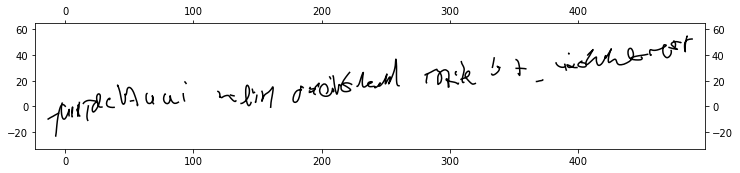

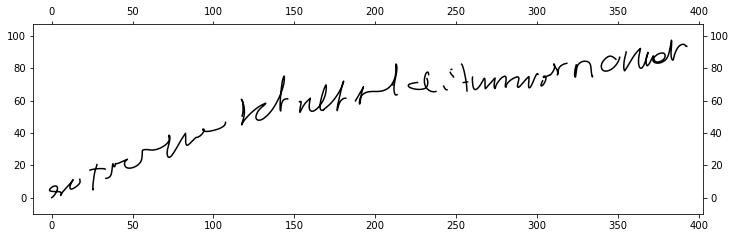

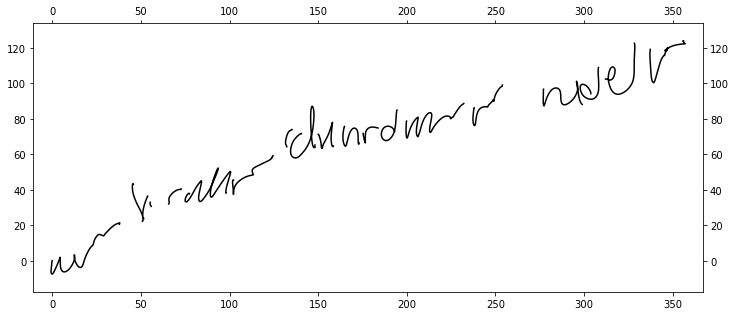

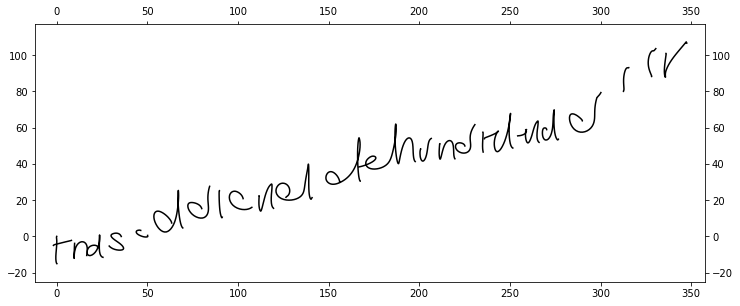

iteration: 4550 of 39000, avg_loss: -2117.69, timeSinceStart: 4320.21, Epoch: 58
iteration: 4600 of 39000, avg_loss: -2137.02, timeSinceStart: 4365.05, Epoch: 58
iteration: 4650 of 39000, avg_loss: -2131.28, timeSinceStart: 4409.94, Epoch: 59
iteration: 4700 of 39000, avg_loss: -2152.81, timeSinceStart: 4454.77, Epoch: 60
iteration: 4750 of 39000, avg_loss: -2135.25, timeSinceStart: 4499.64, Epoch: 60


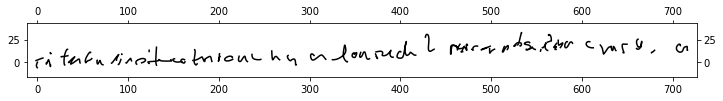

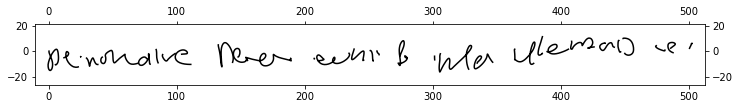

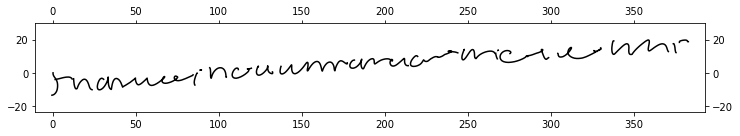

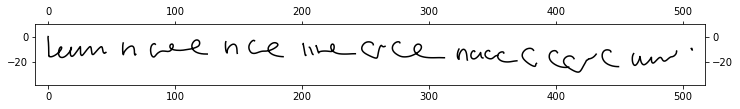

iteration: 4800 of 39000, avg_loss: -2147.56, timeSinceStart: 4551.74, Epoch: 61
iteration: 4850 of 39000, avg_loss: -2122.40, timeSinceStart: 4596.59, Epoch: 62
iteration: 4900 of 39000, avg_loss: -2130.80, timeSinceStart: 4641.52, Epoch: 62
iteration: 4950 of 39000, avg_loss: -2146.87, timeSinceStart: 4686.34, Epoch: 63
iteration: 5000 of 39000, avg_loss: -2147.27, timeSinceStart: 4731.34, Epoch: 64


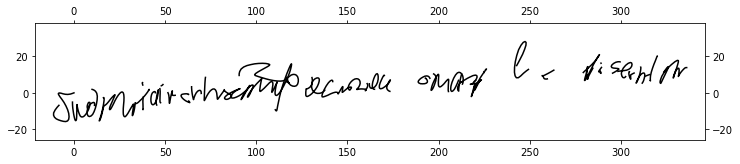

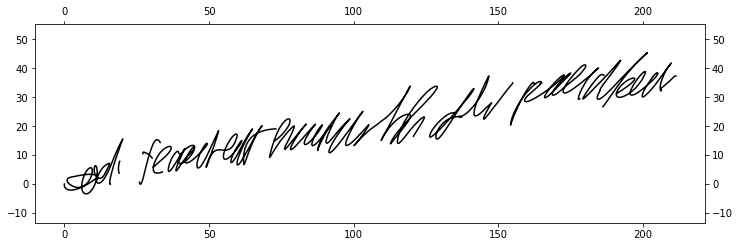

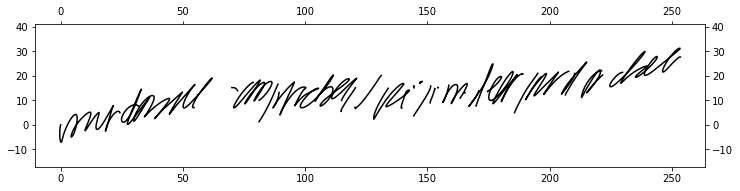

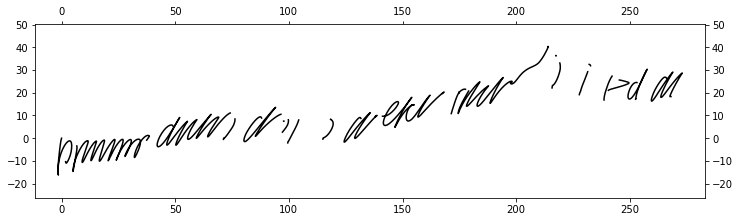

iteration: 5050 of 39000, avg_loss: -2154.70, timeSinceStart: 4783.38, Epoch: 64
iteration: 5100 of 39000, avg_loss: -2142.84, timeSinceStart: 4828.21, Epoch: 65
iteration: 5150 of 39000, avg_loss: -2130.21, timeSinceStart: 4873.11, Epoch: 66
iteration: 5200 of 39000, avg_loss: -2150.08, timeSinceStart: 4917.80, Epoch: 66
iteration: 5250 of 39000, avg_loss: -2156.29, timeSinceStart: 4962.46, Epoch: 67


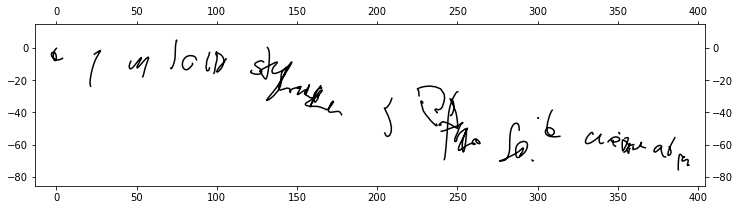

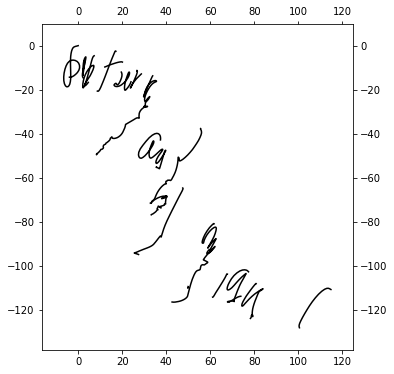

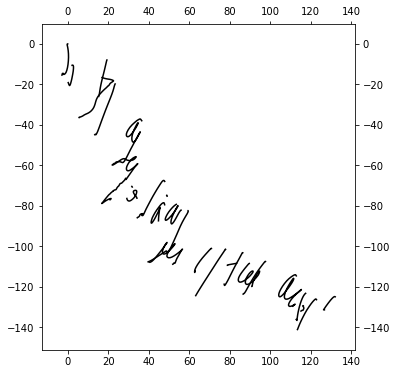

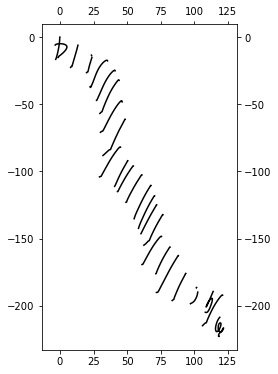

iteration: 5300 of 39000, avg_loss: -2120.88, timeSinceStart: 5014.43, Epoch: 67
iteration: 5350 of 39000, avg_loss: -2151.37, timeSinceStart: 5058.93, Epoch: 68
iteration: 5400 of 39000, avg_loss: -2143.69, timeSinceStart: 5103.58, Epoch: 69
iteration: 5450 of 39000, avg_loss: -2150.86, timeSinceStart: 5148.22, Epoch: 69
iteration: 5500 of 39000, avg_loss: -2173.23, timeSinceStart: 5192.87, Epoch: 70


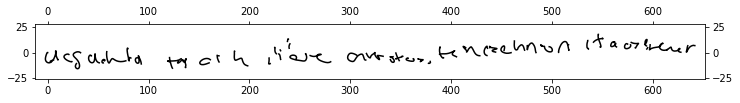

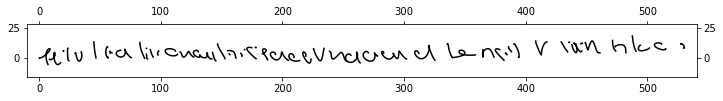

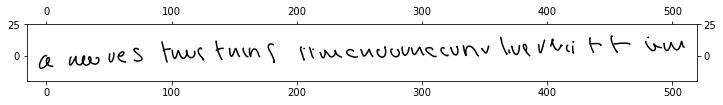

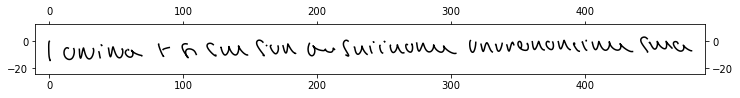

iteration: 5550 of 39000, avg_loss: -2148.17, timeSinceStart: 5244.94, Epoch: 71
iteration: 5600 of 39000, avg_loss: -2155.07, timeSinceStart: 5289.58, Epoch: 71
iteration: 5650 of 39000, avg_loss: -2166.35, timeSinceStart: 5334.26, Epoch: 72
iteration: 5700 of 39000, avg_loss: -2156.73, timeSinceStart: 5378.99, Epoch: 73
iteration: 5750 of 39000, avg_loss: -2179.62, timeSinceStart: 5423.85, Epoch: 73


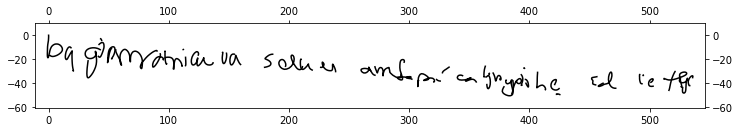

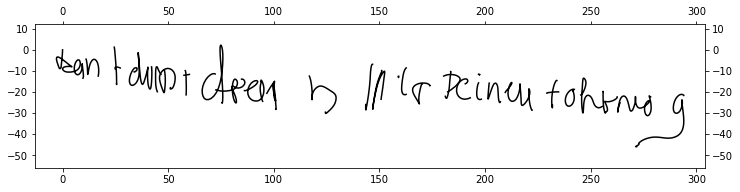

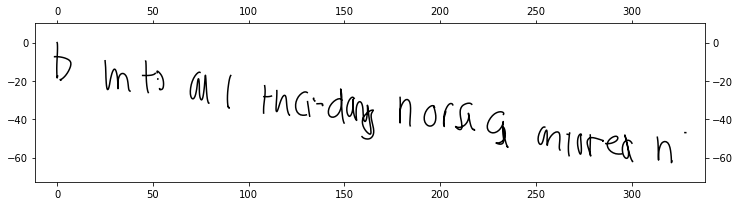

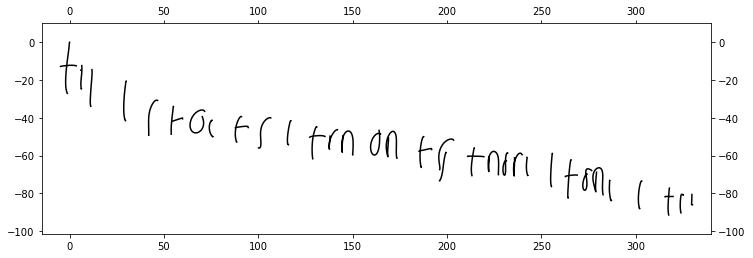

iteration: 5800 of 39000, avg_loss: -2169.75, timeSinceStart: 5476.09, Epoch: 74
iteration: 5850 of 39000, avg_loss: -2175.59, timeSinceStart: 5520.88, Epoch: 75
iteration: 5900 of 39000, avg_loss: -2180.80, timeSinceStart: 5565.81, Epoch: 75
iteration: 5950 of 39000, avg_loss: -2175.58, timeSinceStart: 5610.63, Epoch: 76
iteration: 6000 of 39000, avg_loss: -2173.62, timeSinceStart: 5655.50, Epoch: 76


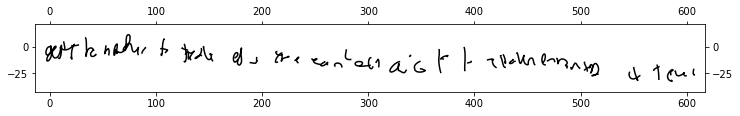

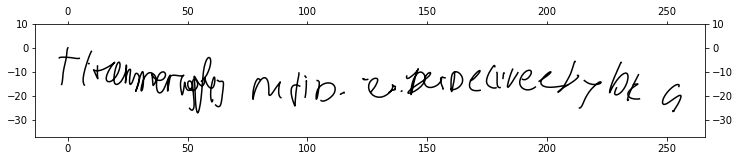

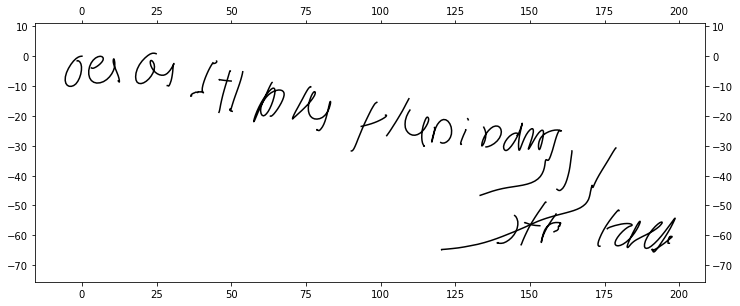

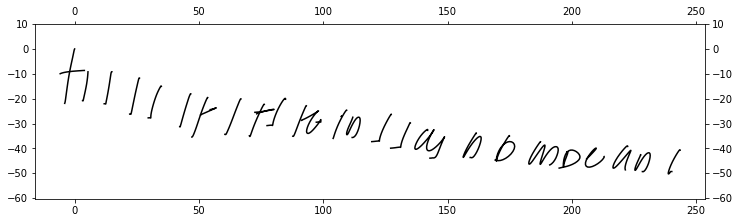

iteration: 6050 of 39000, avg_loss: -2179.80, timeSinceStart: 5707.67, Epoch: 77
iteration: 6100 of 39000, avg_loss: -2177.00, timeSinceStart: 5752.46, Epoch: 78
iteration: 6150 of 39000, avg_loss: -2185.16, timeSinceStart: 5797.30, Epoch: 78
iteration: 6200 of 39000, avg_loss: -2194.06, timeSinceStart: 5842.17, Epoch: 79
iteration: 6250 of 39000, avg_loss: -2196.44, timeSinceStart: 5887.12, Epoch: 80


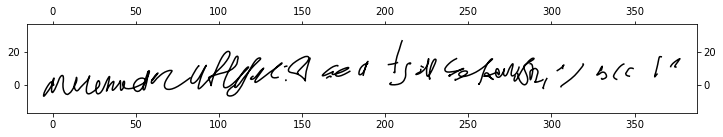

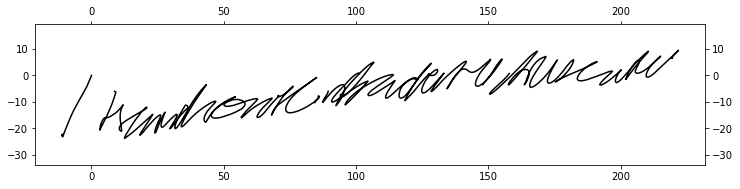

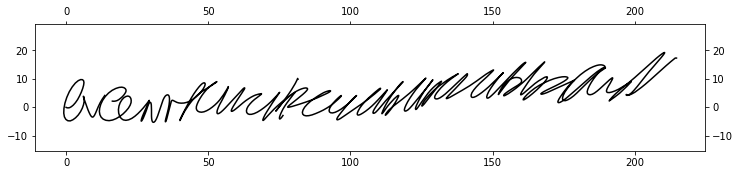

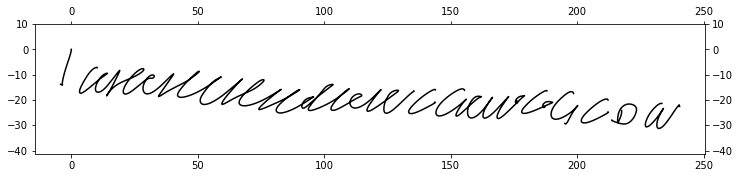

iteration: 6300 of 39000, avg_loss: -2185.58, timeSinceStart: 5939.16, Epoch: 80
iteration: 6350 of 39000, avg_loss: -2176.78, timeSinceStart: 5984.06, Epoch: 81
iteration: 6400 of 39000, avg_loss: -2189.38, timeSinceStart: 6028.97, Epoch: 82
iteration: 6450 of 39000, avg_loss: -2194.16, timeSinceStart: 6073.83, Epoch: 82
iteration: 6500 of 39000, avg_loss: -2190.00, timeSinceStart: 6118.67, Epoch: 83


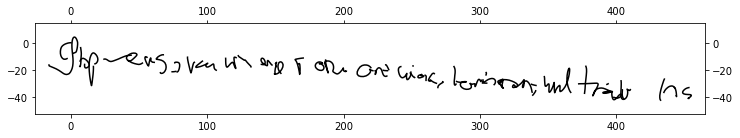

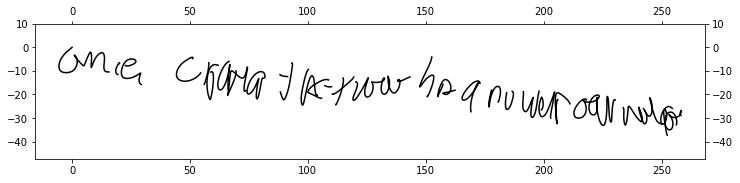

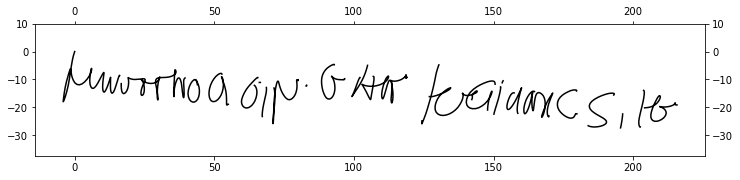

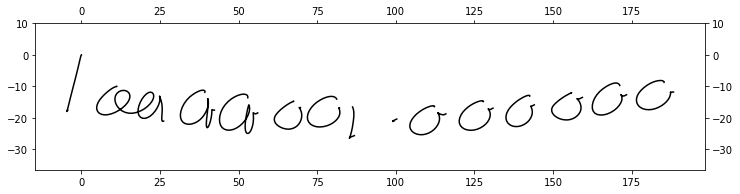

iteration: 6550 of 39000, avg_loss: -2185.50, timeSinceStart: 6170.78, Epoch: 83
iteration: 6600 of 39000, avg_loss: -2208.24, timeSinceStart: 6215.69, Epoch: 84
iteration: 6650 of 39000, avg_loss: -2199.45, timeSinceStart: 6260.64, Epoch: 85
iteration: 6700 of 39000, avg_loss: -2213.72, timeSinceStart: 6305.55, Epoch: 85
iteration: 6750 of 39000, avg_loss: -2196.05, timeSinceStart: 6350.50, Epoch: 86


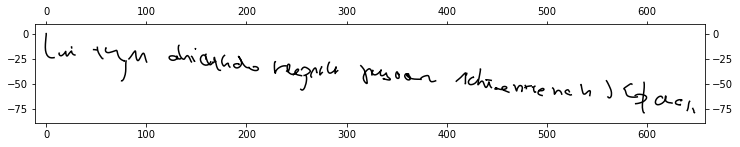

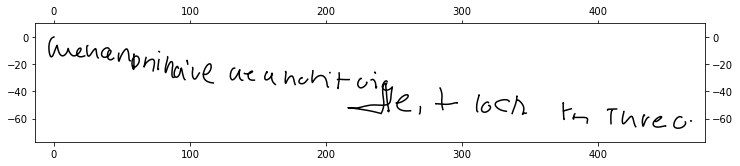

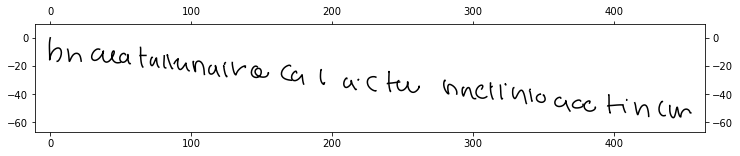

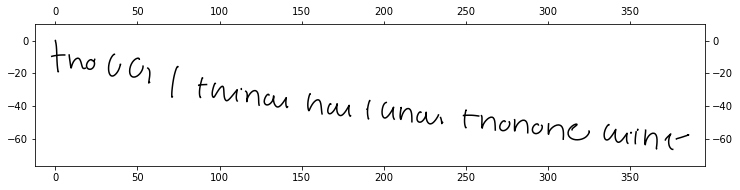

iteration: 6800 of 39000, avg_loss: -2210.41, timeSinceStart: 6402.79, Epoch: 87
iteration: 6850 of 39000, avg_loss: -2193.38, timeSinceStart: 6447.59, Epoch: 87
iteration: 6900 of 39000, avg_loss: -2185.33, timeSinceStart: 6492.51, Epoch: 88
iteration: 6950 of 39000, avg_loss: -2198.64, timeSinceStart: 6537.40, Epoch: 89
iteration: 7000 of 39000, avg_loss: -2198.63, timeSinceStart: 6582.31, Epoch: 89


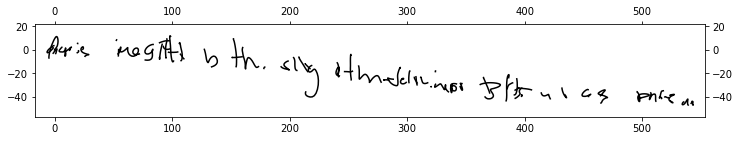

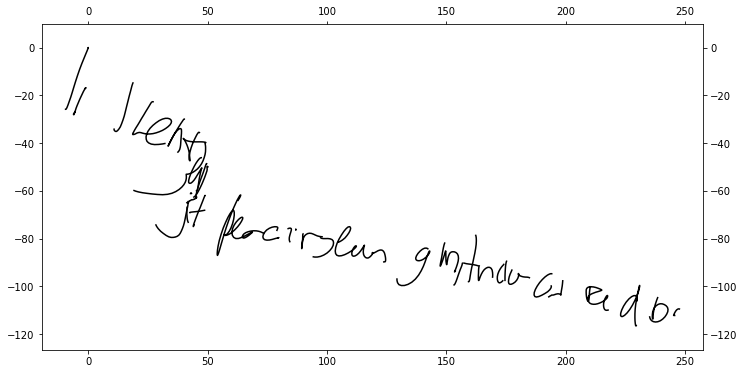

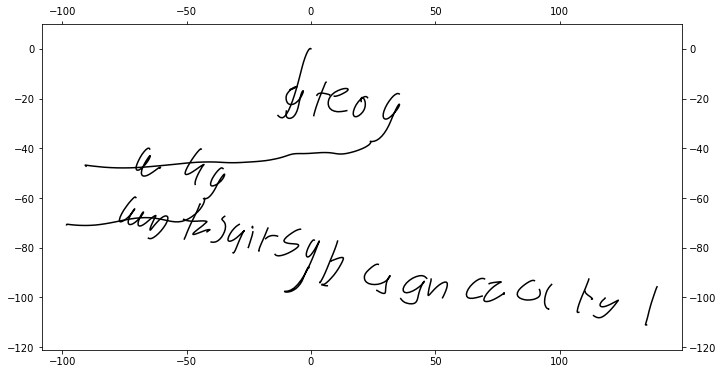

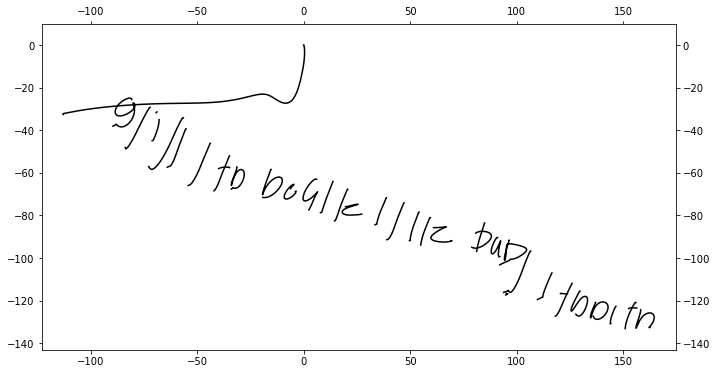

iteration: 7050 of 39000, avg_loss: -2218.12, timeSinceStart: 6634.36, Epoch: 90
iteration: 7100 of 39000, avg_loss: -2200.07, timeSinceStart: 6679.16, Epoch: 91
iteration: 7150 of 39000, avg_loss: -2204.56, timeSinceStart: 6723.97, Epoch: 91
iteration: 7200 of 39000, avg_loss: -2201.97, timeSinceStart: 6768.79, Epoch: 92
iteration: 7250 of 39000, avg_loss: -2220.27, timeSinceStart: 6813.62, Epoch: 92


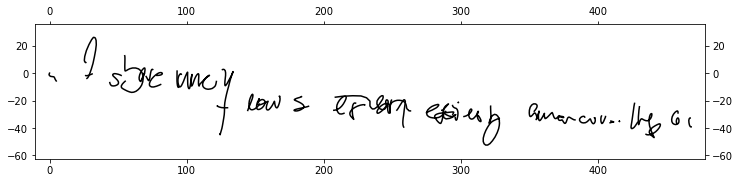

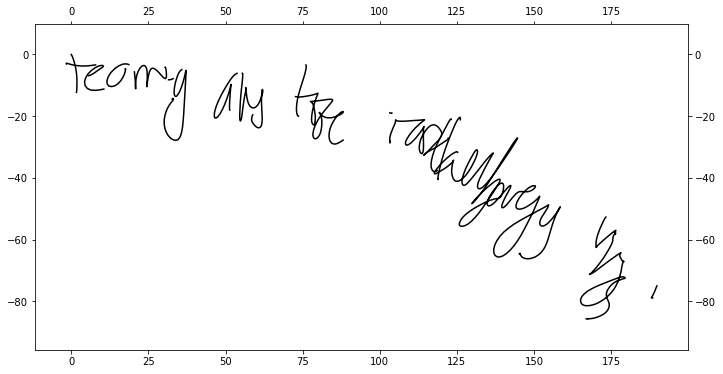

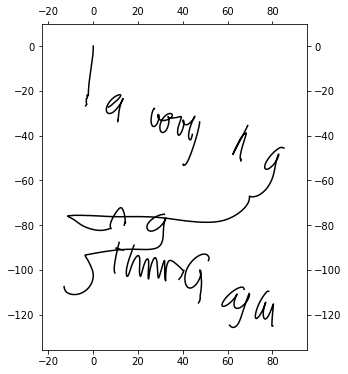

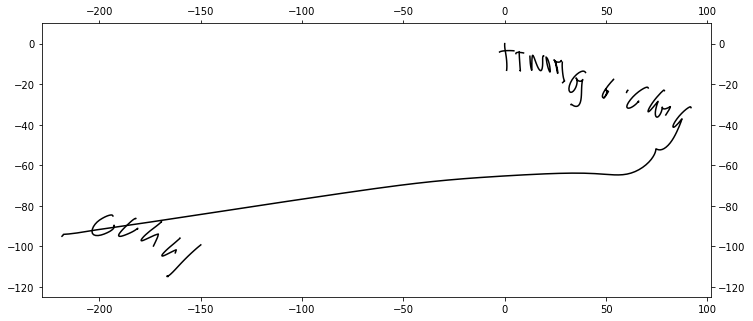

iteration: 7300 of 39000, avg_loss: -2208.57, timeSinceStart: 6865.82, Epoch: 93
iteration: 7350 of 39000, avg_loss: -2222.64, timeSinceStart: 6910.66, Epoch: 94
iteration: 7400 of 39000, avg_loss: -2208.91, timeSinceStart: 6955.56, Epoch: 94
iteration: 7450 of 39000, avg_loss: -2223.16, timeSinceStart: 7000.42, Epoch: 95
iteration: 7500 of 39000, avg_loss: -2218.52, timeSinceStart: 7045.31, Epoch: 96


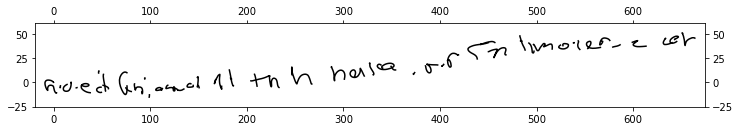

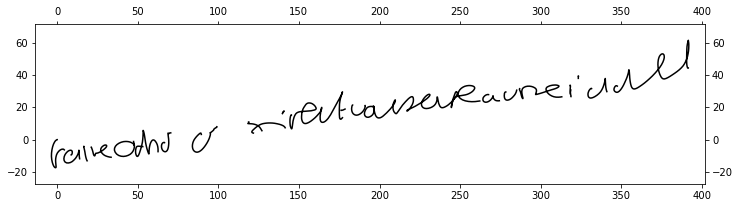

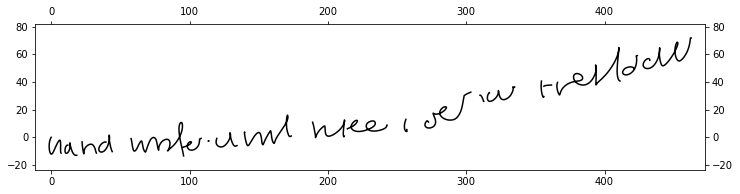

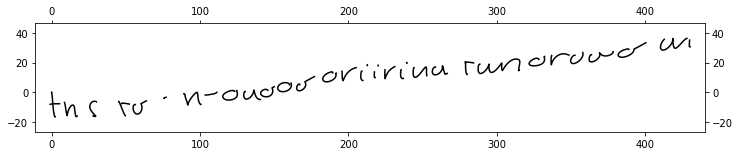

iteration: 7550 of 39000, avg_loss: -2197.84, timeSinceStart: 7097.44, Epoch: 96
iteration: 7600 of 39000, avg_loss: -2220.25, timeSinceStart: 7142.20, Epoch: 97
iteration: 7650 of 39000, avg_loss: -2204.67, timeSinceStart: 7187.10, Epoch: 98
iteration: 7700 of 39000, avg_loss: -2219.69, timeSinceStart: 7231.98, Epoch: 98
iteration: 7750 of 39000, avg_loss: -2219.38, timeSinceStart: 7276.89, Epoch: 99


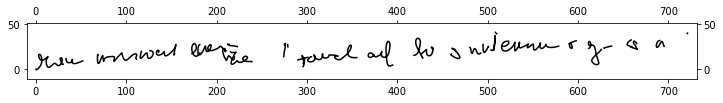

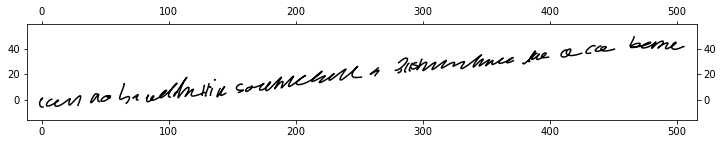

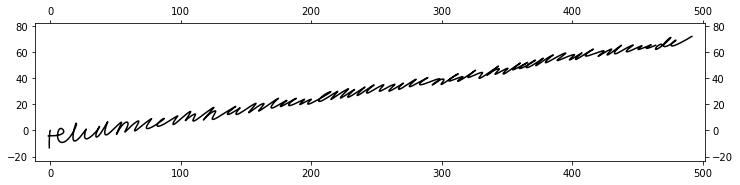

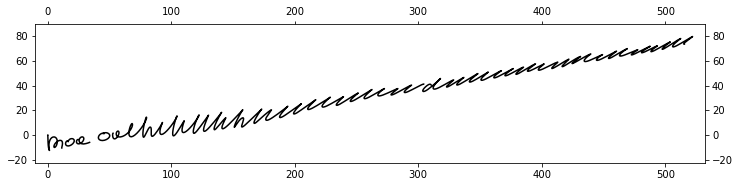

iteration: 7800 of 39000, avg_loss: -2213.90, timeSinceStart: 7328.90, Epoch: 100
iteration: 7850 of 39000, avg_loss: -2215.88, timeSinceStart: 7373.75, Epoch: 100
iteration: 7900 of 39000, avg_loss: -2219.29, timeSinceStart: 7418.67, Epoch: 101
iteration: 7950 of 39000, avg_loss: -2228.85, timeSinceStart: 7463.50, Epoch: 101
iteration: 8000 of 39000, avg_loss: -2237.80, timeSinceStart: 7508.38, Epoch: 102


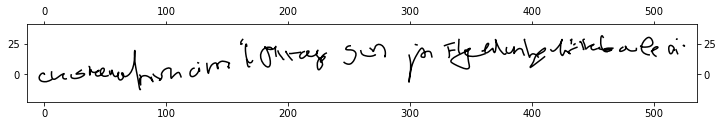

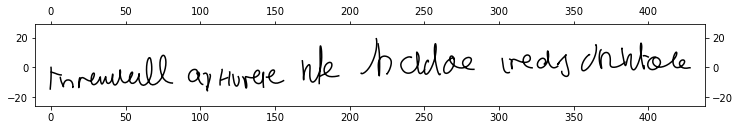

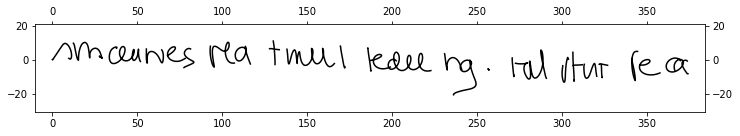

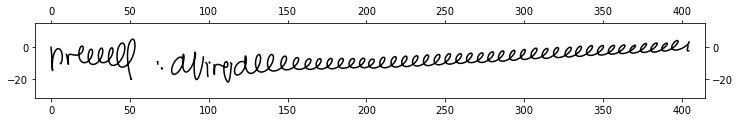

iteration: 8050 of 39000, avg_loss: -2218.93, timeSinceStart: 7560.46, Epoch: 103
iteration: 8100 of 39000, avg_loss: -2235.96, timeSinceStart: 7605.32, Epoch: 103
iteration: 8150 of 39000, avg_loss: -2242.46, timeSinceStart: 7650.19, Epoch: 104
iteration: 8200 of 39000, avg_loss: -2223.04, timeSinceStart: 7695.06, Epoch: 105
iteration: 8250 of 39000, avg_loss: -2211.94, timeSinceStart: 7739.86, Epoch: 105


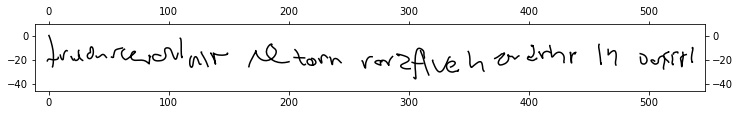

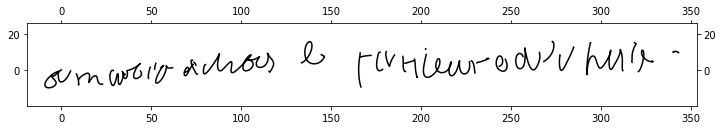

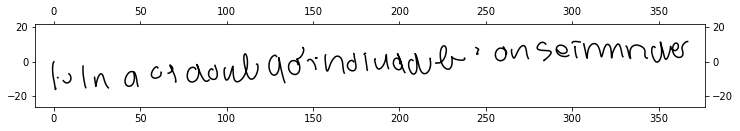

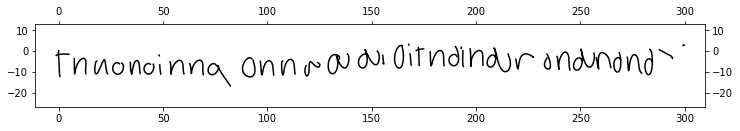

iteration: 8300 of 39000, avg_loss: -2234.47, timeSinceStart: 7792.03, Epoch: 106
iteration: 8350 of 39000, avg_loss: -2221.73, timeSinceStart: 7836.92, Epoch: 107
iteration: 8400 of 39000, avg_loss: -2220.73, timeSinceStart: 7881.88, Epoch: 107
iteration: 8450 of 39000, avg_loss: -2241.08, timeSinceStart: 7926.78, Epoch: 108
iteration: 8500 of 39000, avg_loss: -2224.38, timeSinceStart: 7971.72, Epoch: 108


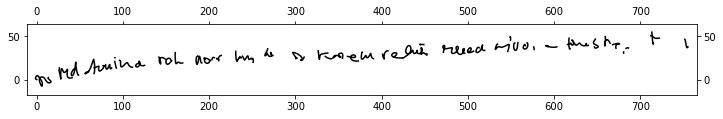

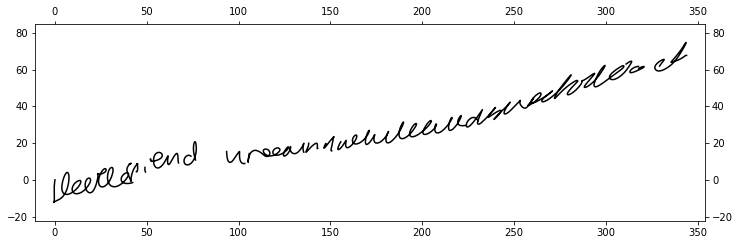

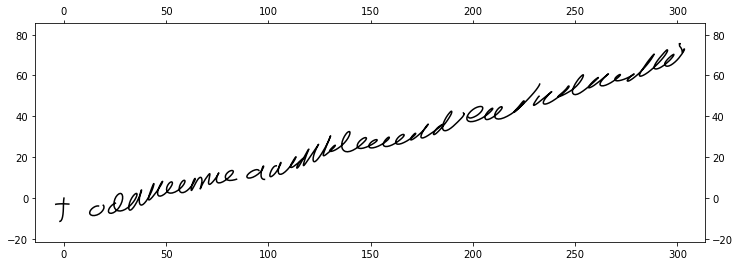

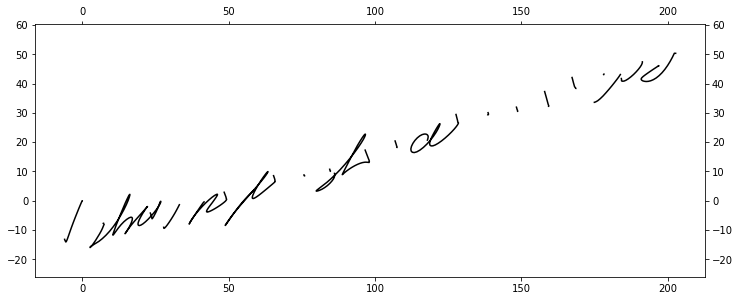

iteration: 8550 of 39000, avg_loss: -2230.90, timeSinceStart: 8023.88, Epoch: 109
iteration: 8600 of 39000, avg_loss: -2254.66, timeSinceStart: 8068.74, Epoch: 110
iteration: 8650 of 39000, avg_loss: -2223.68, timeSinceStart: 8113.68, Epoch: 110
iteration: 8700 of 39000, avg_loss: -2238.80, timeSinceStart: 8158.61, Epoch: 111
iteration: 8750 of 39000, avg_loss: -2234.12, timeSinceStart: 8203.53, Epoch: 112


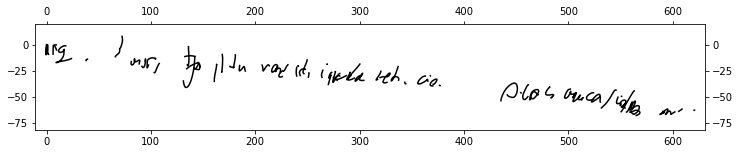

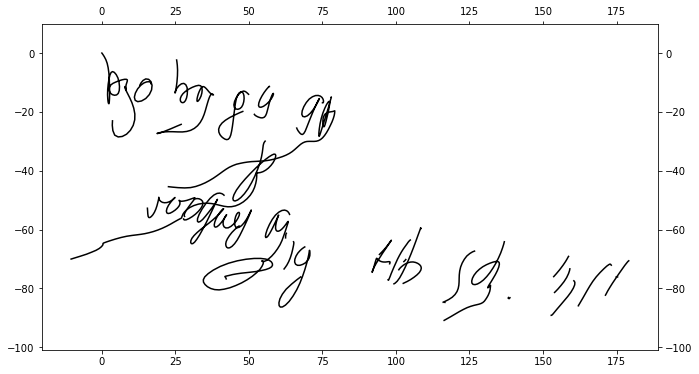

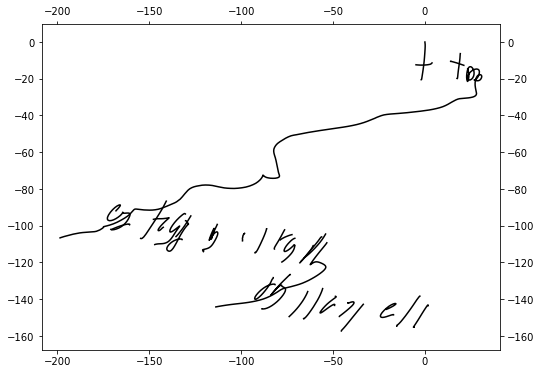

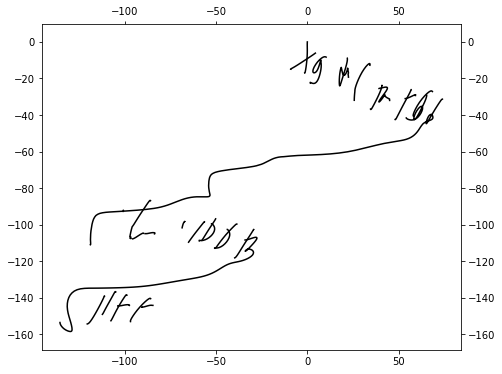

iteration: 8800 of 39000, avg_loss: -2252.17, timeSinceStart: 8255.71, Epoch: 112
iteration: 8850 of 39000, avg_loss: -2256.80, timeSinceStart: 8300.44, Epoch: 113
iteration: 8900 of 39000, avg_loss: -2241.57, timeSinceStart: 8345.25, Epoch: 114
iteration: 8950 of 39000, avg_loss: -2247.18, timeSinceStart: 8390.09, Epoch: 114
iteration: 9000 of 39000, avg_loss: -2254.29, timeSinceStart: 8434.98, Epoch: 115


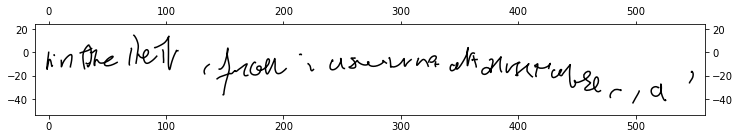

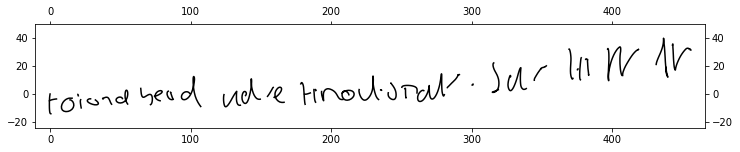

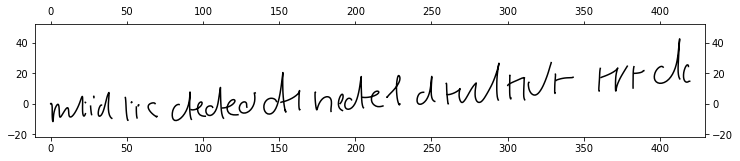

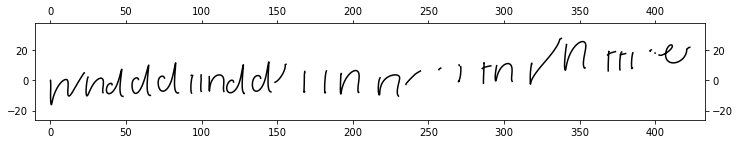

iteration: 9050 of 39000, avg_loss: -2261.82, timeSinceStart: 8487.32, Epoch: 116
iteration: 9100 of 39000, avg_loss: -2245.69, timeSinceStart: 8532.14, Epoch: 116
iteration: 9150 of 39000, avg_loss: -2240.71, timeSinceStart: 8577.04, Epoch: 117
iteration: 9200 of 39000, avg_loss: -2250.01, timeSinceStart: 8621.94, Epoch: 117
iteration: 9250 of 39000, avg_loss: -2237.49, timeSinceStart: 8666.91, Epoch: 118


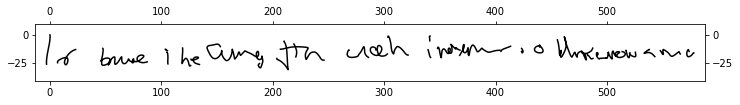

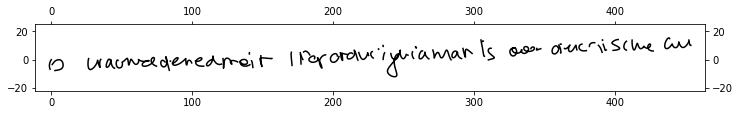

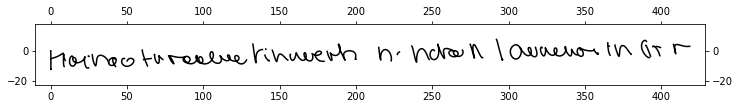

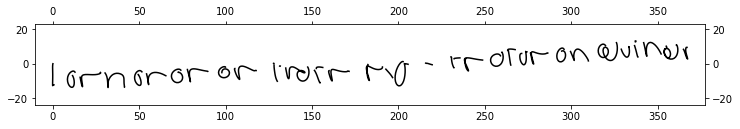

iteration: 9300 of 39000, avg_loss: -2252.86, timeSinceStart: 8719.16, Epoch: 119
iteration: 9350 of 39000, avg_loss: -2246.88, timeSinceStart: 8764.02, Epoch: 119
iteration: 9400 of 39000, avg_loss: -2255.67, timeSinceStart: 8808.91, Epoch: 120
iteration: 9450 of 39000, avg_loss: -2247.97, timeSinceStart: 8853.79, Epoch: 121
iteration: 9500 of 39000, avg_loss: -2259.34, timeSinceStart: 8898.67, Epoch: 121


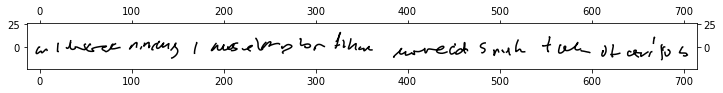

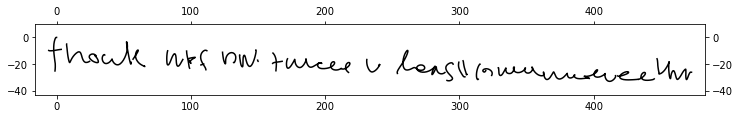

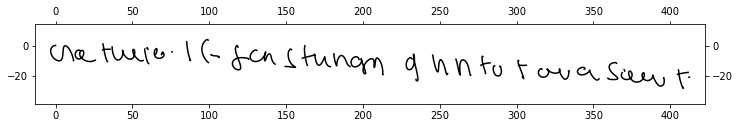

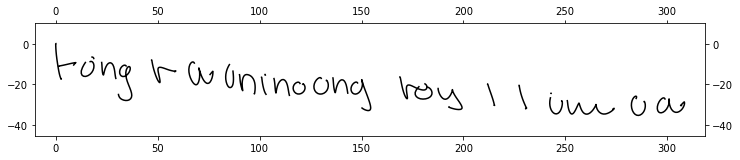

iteration: 9550 of 39000, avg_loss: -2273.18, timeSinceStart: 8950.73, Epoch: 122
iteration: 9600 of 39000, avg_loss: -2255.08, timeSinceStart: 8995.55, Epoch: 123
iteration: 9650 of 39000, avg_loss: -2259.66, timeSinceStart: 9040.47, Epoch: 123
iteration: 9700 of 39000, avg_loss: -2278.49, timeSinceStart: 9085.36, Epoch: 124
iteration: 9750 of 39000, avg_loss: -2266.34, timeSinceStart: 9130.25, Epoch: 125


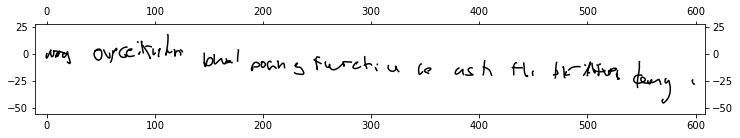

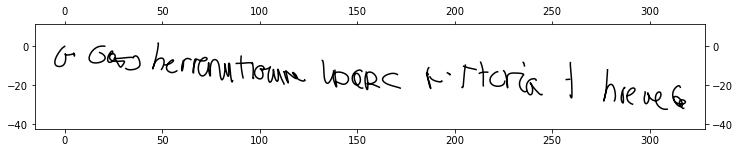

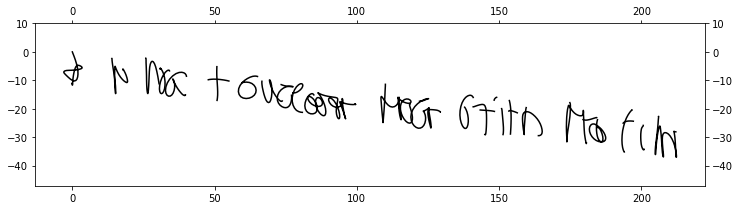

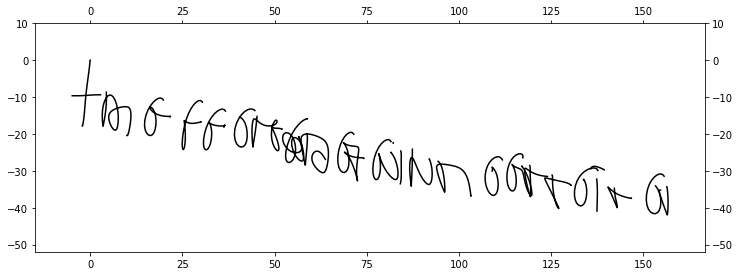

iteration: 9800 of 39000, avg_loss: -2255.79, timeSinceStart: 9182.36, Epoch: 125
iteration: 9850 of 39000, avg_loss: -2266.41, timeSinceStart: 9227.19, Epoch: 126
iteration: 9900 of 39000, avg_loss: -2265.96, timeSinceStart: 9271.99, Epoch: 126
iteration: 9950 of 39000, avg_loss: -2263.89, timeSinceStart: 9316.88, Epoch: 127
iteration: 10000 of 39000, avg_loss: -2256.03, timeSinceStart: 9361.70, Epoch: 128


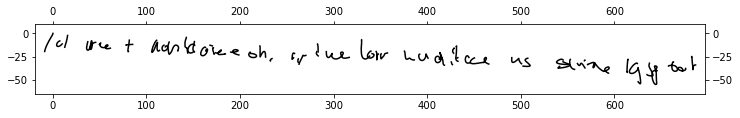

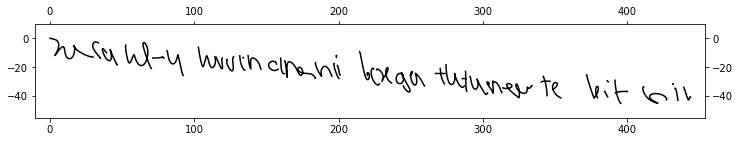

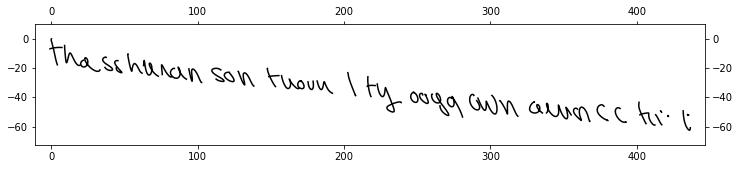

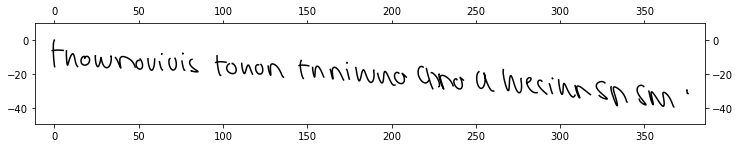

iteration: 10050 of 39000, avg_loss: -2269.74, timeSinceStart: 9413.99, Epoch: 128
iteration: 10100 of 39000, avg_loss: -2279.14, timeSinceStart: 9458.81, Epoch: 129
iteration: 10150 of 39000, avg_loss: -2275.57, timeSinceStart: 9503.78, Epoch: 130
iteration: 10200 of 39000, avg_loss: -2271.62, timeSinceStart: 9548.66, Epoch: 130
iteration: 10250 of 39000, avg_loss: -2272.81, timeSinceStart: 9593.61, Epoch: 131


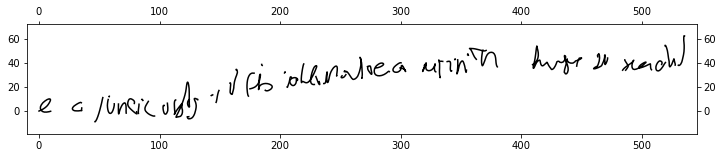

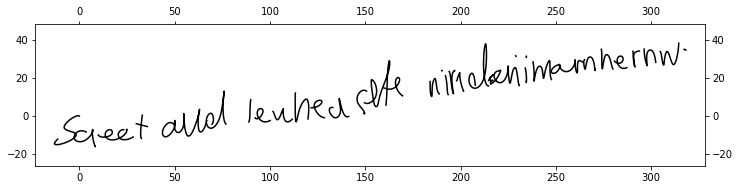

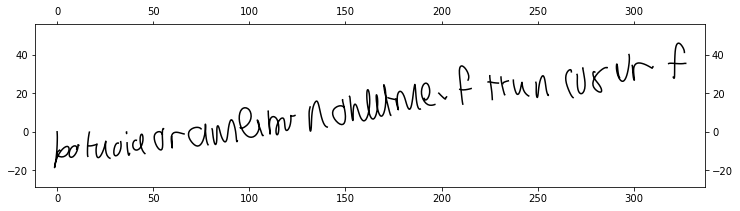

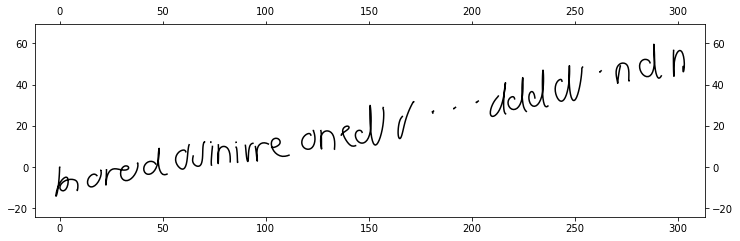

iteration: 10300 of 39000, avg_loss: -2271.91, timeSinceStart: 9645.73, Epoch: 132
iteration: 10350 of 39000, avg_loss: -2287.06, timeSinceStart: 9690.35, Epoch: 132
iteration: 10400 of 39000, avg_loss: -2275.60, timeSinceStart: 9735.25, Epoch: 133
iteration: 10450 of 39000, avg_loss: -2280.70, timeSinceStart: 9780.07, Epoch: 133
iteration: 10500 of 39000, avg_loss: -2282.00, timeSinceStart: 9824.98, Epoch: 134


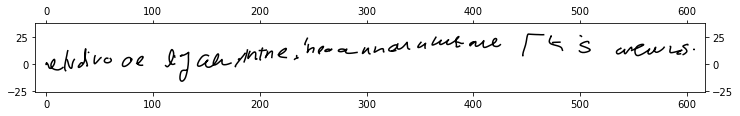

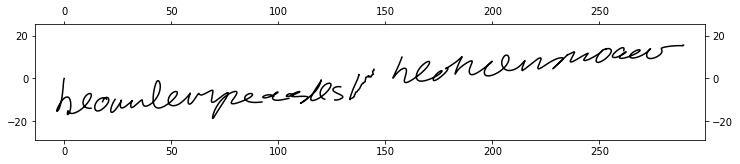

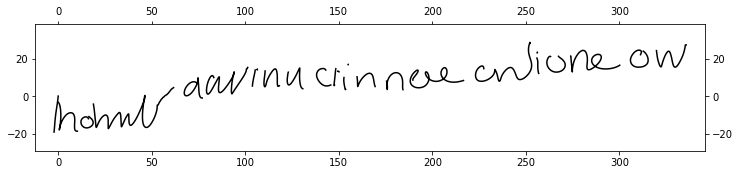

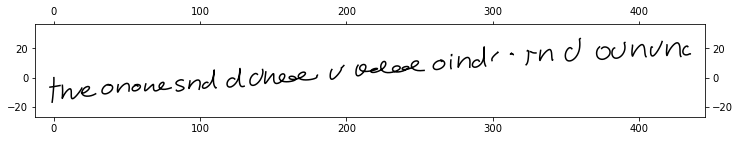

iteration: 10550 of 39000, avg_loss: -2266.27, timeSinceStart: 9877.07, Epoch: 135
iteration: 10600 of 39000, avg_loss: -2278.05, timeSinceStart: 9921.76, Epoch: 135
iteration: 10650 of 39000, avg_loss: -2274.12, timeSinceStart: 9966.58, Epoch: 136
iteration: 10700 of 39000, avg_loss: -2279.50, timeSinceStart: 10011.43, Epoch: 137
iteration: 10750 of 39000, avg_loss: -2279.44, timeSinceStart: 10056.28, Epoch: 137


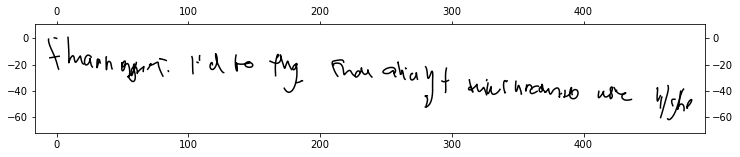

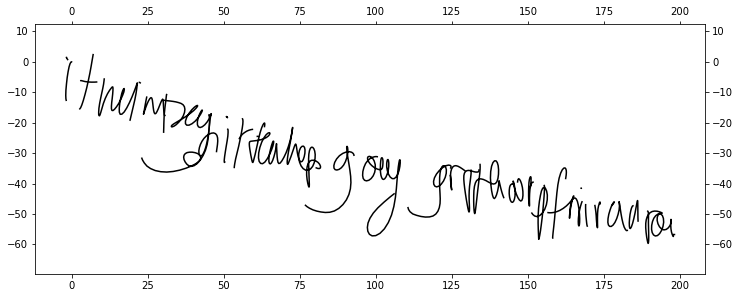

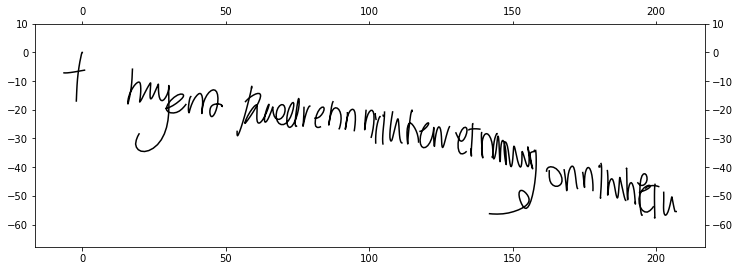

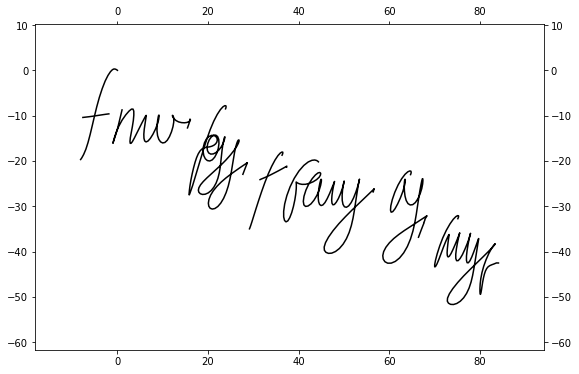

iteration: 10800 of 39000, avg_loss: -2273.49, timeSinceStart: 10108.44, Epoch: 138
iteration: 10850 of 39000, avg_loss: -2292.94, timeSinceStart: 10153.14, Epoch: 139
iteration: 10900 of 39000, avg_loss: -2275.39, timeSinceStart: 10198.04, Epoch: 139
iteration: 10950 of 39000, avg_loss: -2289.18, timeSinceStart: 10242.96, Epoch: 140
iteration: 11000 of 39000, avg_loss: -2272.04, timeSinceStart: 10287.87, Epoch: 141


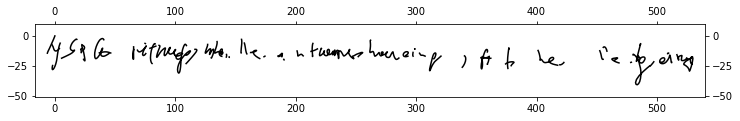

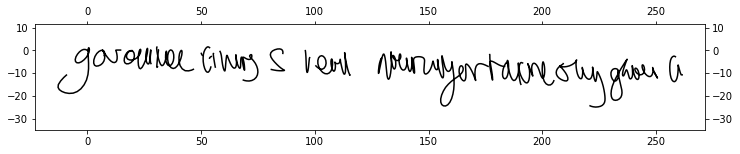

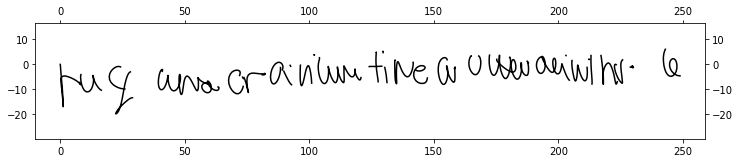

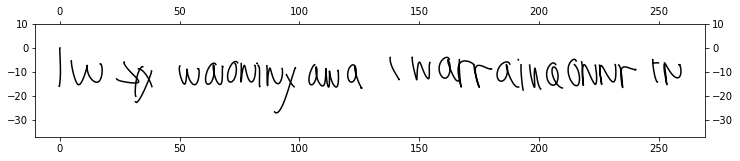

iteration: 11050 of 39000, avg_loss: -2283.33, timeSinceStart: 10339.97, Epoch: 141
iteration: 11100 of 39000, avg_loss: -2284.53, timeSinceStart: 10384.67, Epoch: 142
iteration: 11150 of 39000, avg_loss: -2291.65, timeSinceStart: 10429.53, Epoch: 142
iteration: 11200 of 39000, avg_loss: -2301.31, timeSinceStart: 10474.39, Epoch: 143
iteration: 11250 of 39000, avg_loss: -2279.36, timeSinceStart: 10519.33, Epoch: 144


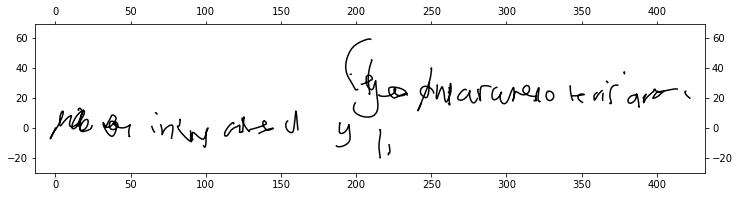

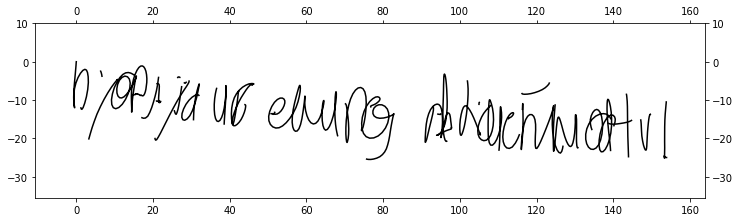

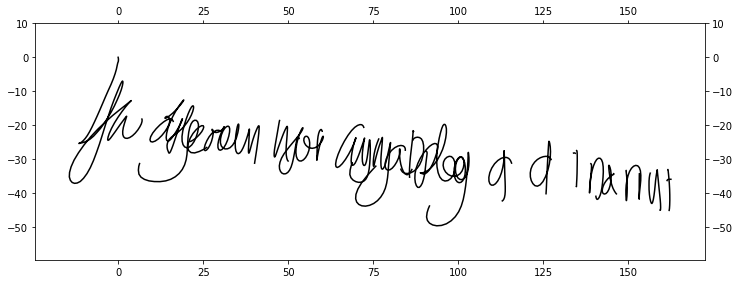

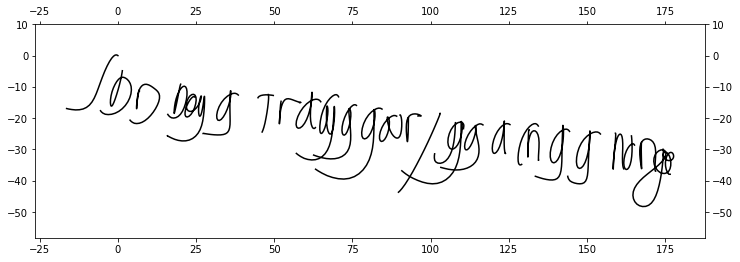

iteration: 11300 of 39000, avg_loss: -2295.99, timeSinceStart: 10571.52, Epoch: 144
iteration: 11350 of 39000, avg_loss: -2281.05, timeSinceStart: 10616.23, Epoch: 145
iteration: 11400 of 39000, avg_loss: -2266.20, timeSinceStart: 10661.07, Epoch: 146
iteration: 11450 of 39000, avg_loss: -2269.54, timeSinceStart: 10705.94, Epoch: 146
iteration: 11500 of 39000, avg_loss: -2291.55, timeSinceStart: 10750.80, Epoch: 147


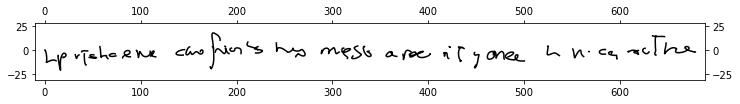

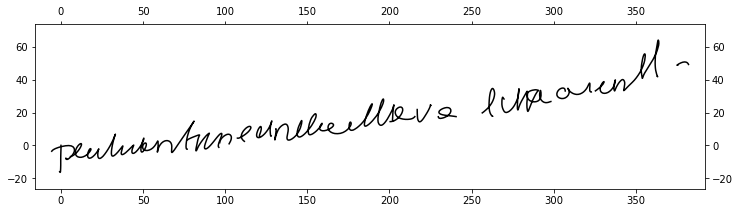

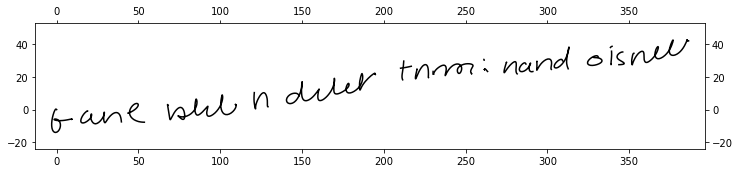

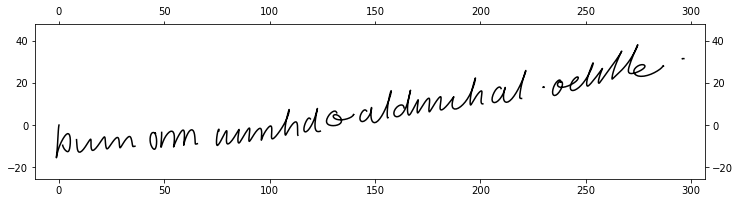

iteration: 11550 of 39000, avg_loss: -2284.87, timeSinceStart: 10802.79, Epoch: 148
iteration: 11600 of 39000, avg_loss: -2282.55, timeSinceStart: 10847.58, Epoch: 148
iteration: 11650 of 39000, avg_loss: -2300.87, timeSinceStart: 10892.50, Epoch: 149
iteration: 11700 of 39000, avg_loss: -2287.30, timeSinceStart: 10937.36, Epoch: 150
iteration: 11750 of 39000, avg_loss: -2289.91, timeSinceStart: 10982.19, Epoch: 150


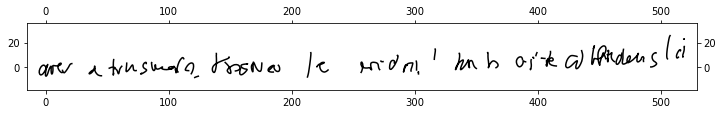

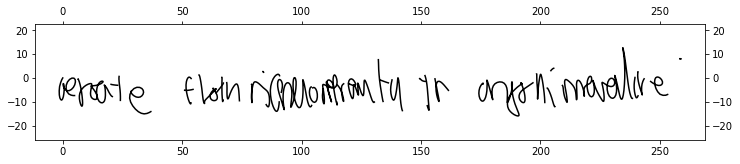

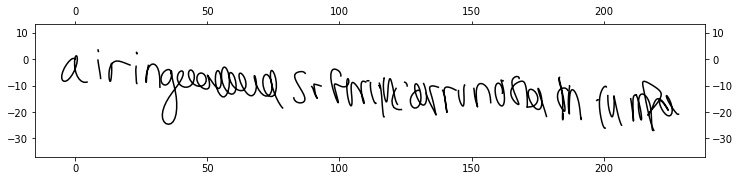

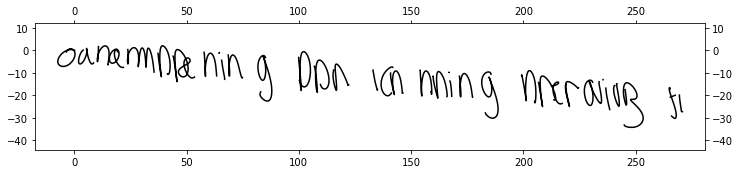

iteration: 11800 of 39000, avg_loss: -2299.38, timeSinceStart: 11034.33, Epoch: 151
iteration: 11850 of 39000, avg_loss: -2298.63, timeSinceStart: 11079.11, Epoch: 151
iteration: 11900 of 39000, avg_loss: -2301.47, timeSinceStart: 11123.91, Epoch: 152
iteration: 11950 of 39000, avg_loss: -2278.00, timeSinceStart: 11168.84, Epoch: 153
iteration: 12000 of 39000, avg_loss: -2302.14, timeSinceStart: 11213.75, Epoch: 153


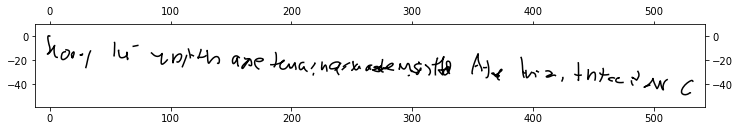

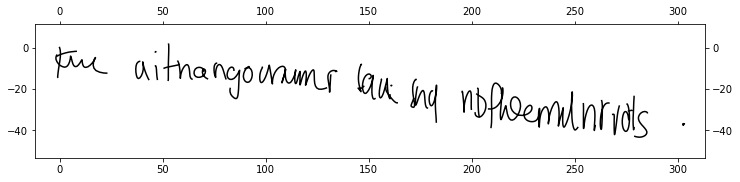

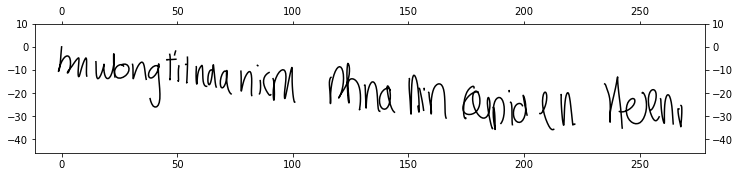

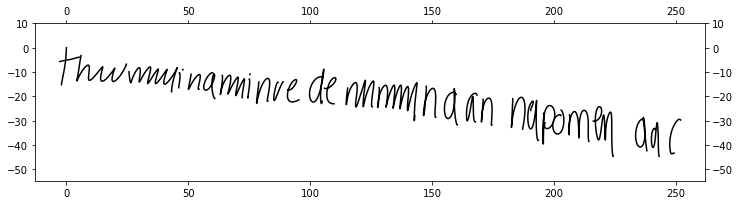

iteration: 12050 of 39000, avg_loss: -2278.88, timeSinceStart: 11266.07, Epoch: 154
iteration: 12100 of 39000, avg_loss: -2284.19, timeSinceStart: 11310.77, Epoch: 155
iteration: 12150 of 39000, avg_loss: -2292.85, timeSinceStart: 11355.61, Epoch: 155
iteration: 12200 of 39000, avg_loss: -2276.54, timeSinceStart: 11400.39, Epoch: 156
iteration: 12250 of 39000, avg_loss: -2307.60, timeSinceStart: 11445.23, Epoch: 157


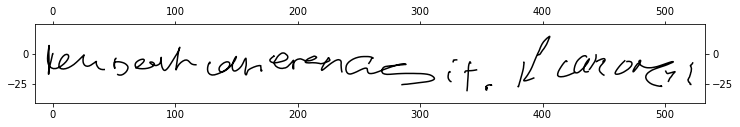

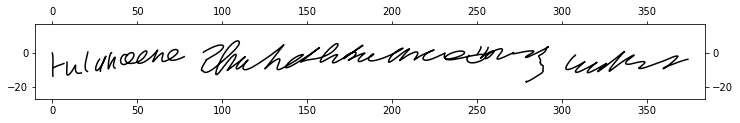

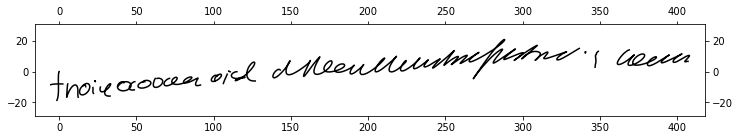

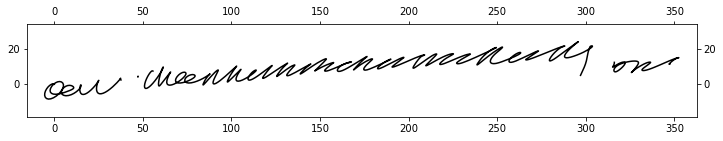

ValueError: Expected parameter loc (Tensor of shape (128, 1199, 40, 2)) of distribution MultivariateNormal(loc: torch.Size([128, 1199, 40, 2]), covariance_matrix: torch.Size([128, 1199, 40, 2, 2])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]],


        ...,


        [[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]],


        [[[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan],
          ...,
          [nan, nan],
          [nan, nan],
          [nan, nan]]]], device='cuda:1', grad_fn=<ExpandBackward>)

In [17]:
train(model, optim, train_dataloader, n_epochs)

In [ ]:
m = Prediction(input_size, hidden_size, 6*n_mixtures+1).to(device)

inputs = torch.randn(batch_size, max_length, input_size, device=device)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs

lengths = torch.tensor([5, 3])

packed_inp = pack_padded_sequence(
    inputs,
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
targets = pack_padded_sequence(
    inputs[:,1:,:],
    lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
    batch_first=True)
packed_inp
targets
h = torch.zeros(1, 2, 4, device=device)
out, out1 = m(packed_inp, h, h)
print("out", out)
nll(out, targets.data)
print(out1)

In [ ]:
h0 = torch.zeros(1, batch_size, hidden_size, device=device)
c0 = torch.zeros(1, batch_size, hidden_size, device=device)
print(inputs.shape, lengths.shape, lengths)
train_batch(m, optim, inputs, lengths, h0, c0)
s = sample(m)
draw(s.cpu())

In [ ]:
start = torch.tensor([0, 0, 0])


In [ ]:
inputs = torch.randn(2, 5, 3)
inputs[:,0, 0:3] = 0
inputs[0,4, 0:2] = 0
inputs[0,1:5, 2] = 0
inputs[0,4, 2] = 1

inputs[1,3:, 0:3] = 0
inputs[1,2, 0:2] = 0
inputs[1,2, 2] = 1
inputs[1,1, 2] = 0
inputs
lengths = torch.tensor([5, 3])
lengths
ps = pack_padded_sequence(
            inputs,
            lengths.cpu().numpy() - 1, # we dont want to pack the entire sequence
            batch_first=True)
lstmLayer = nn.LSTM(3, 4, batch_first=True)
linLayer = nn.Linear(4, 7)


lstmout, _ = lstmLayer(ps)
lstmout
torch.cat((ps.data,lstmout.data), dim=-1)
linLayer(lstmLayer(ps)[0][0])
pad_packed_sequence(lstmLayer(ps)[0], batch_first=True)
